# Dorothea cut analysis

In [1]:
import os
import functools
import itertools
import time
import datetime
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import pandas as pd

import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt
import invisible_cities.database.load_db as dbf
import invisible_cities.reco.xy_algorithms as xyf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io.kdst_io as kdstio

from invisible_cities.icaro.hst_functions import hist
from invisible_cities.icaro.hst_functions import hist2d
from invisible_cities.icaro.hst_functions import hist2d_profile
from invisible_cities.icaro.hst_functions import labels

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units_c import units

Running on  Thu Oct 26 12:36:30 2017


#### General plotting options

In [2]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 12
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

#### Load PMT and SiPM info

In [3]:
run_db = 4670
DataSiPM = dbf.DataSiPM(run_db)
DataPMT = dbf.DataPMT(run_db)

#### Function to calculate lifetime

In [4]:
def lifetime_calculation(z, zrange, energy, erange, elim_min, elim_max, slope_min, slope_max, axes):
    low_cut   = elim_min * np.exp(-slope_min*z)
    high_cut  = elim_max * np.exp(-slope_max*z)
    sel       = coref.in_range(energy, low_cut, high_cut) # remove low and high E background

    axes.hist2d(z, energy, (100, 50), range=(zrange, erange))
    x, y, u_y = fitf.profileX(z[sel], energy[sel], 100, xrange=zrange, yrange=erange)

    axes.plot(x, y, profOpt)
    axes.plot(z,  low_cut, "k.")
    axes.plot(z, high_cut, "k.")

    Zrange_LT = zrange
    
    seed = np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
    f    = fitf.fit(fitf.expo, x, y, seed, fit_range=Zrange_LT, sigma=u_y)

    axes.plot(x, f.fn(x), fitOpt, lw=4)
    print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
    print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
    print("Chi2          = {:.2f}          \n".format(f.chi2))

    axes.text(zrange[0] + 0.1*(zrange[1]-zrange[0]), erange[0] + 1000, \
                "Lifetime = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]), color = "white", fontsize = 30)
    
    labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")

    return corrf.LifetimeCorrection(-f.values[1], f.errors[1])

In [5]:
def labels_ax(ax, x_label, y_label, title):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

In [6]:
def plot_var(runNum, dst, zCorr, XYcorr, limits, weight_val = 1., fExtra = False, pes2keV = 1.):        
    weight = [1./weight_val]*len(dst)
    ratio = dst.S2e/dst.S1e
    
    fig = plt.figure(figsize=(16, 4*2))
    st = fig.suptitle("Run {}".format(runNum), fontsize = 20)

    ax = fig.add_subplot(241)
    ax.hist(dst.S1e, 100, limits["s1e"], weights = weight)
    labels_ax(ax, "pes", "Rate (Hz)", "S1 cathode energy")
    
    ax = fig.add_subplot(242)
    ax.hist(dst.S2e * pes2keV, 100, np.array(limits["s2e_pes"]) * pes2keV, weights = weight, alpha = 0.5)
    labels_ax(ax, "keV", "Rate (Hz)", "S2 cathode energy")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])     
    ax2 = ax.twinx()
    ax2.hist(dst.S2e * pes2keV, 100, np.array(limits["s2e_pes"]) * pes2keV, weights = weight, \
            alpha = 0.25, color="red")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])   
    plt.yscale("log")
    
    ax1 = fig.add_subplot(243)
    ax1.hist(dst.S2e * zCorr(dst.Z.values).value * XYcorr(dst.X.values, dst.Y.values).value * pes2keV, 100, \
         np.array(limits["s2e"]) * pes2keV, weights = weight, alpha = 0.5)
    labels_ax(ax1, "keV", "Rate (Hz)", "")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])    

    ax2 = ax1.twinx()
    ax2.hist(dst.S2e * zCorr(dst.Z.values).value * XYcorr(dst.X.values, dst.Y.values).value * pes2keV, 100, \
         np.array(limits["s2e"]) * pes2keV, weights = weight, alpha = 0.25, color = "red")
    labels_ax(ax2, "keV", "Rate (Hz)", "S2 cathode energy XYZ-corr")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])   
    plt.yscale("log")
    
    ax = fig.add_subplot(244)
    ax.hist(ratio, 100, limits["ratio"], weights = weight)
    labels_ax(ax, "S2S1 Ratio", "Rate (Hz)", "S2S1 ratio")
        
    ax = fig.add_subplot(245)
    ax.hist2d(dst.S1e, dst.S2e * pes2keV, 50, [limits["s1e"], np.array(limits["s2e"]) * pes2keV])
#    ax.hist2d(dst.S1e, dst.S2e * zCorr(dst.Z.values).value * XYcorr(dst.X.values, dst.Y.values).value * pes2keV, 50, [limits["s1e"], np.array(limits["s2e"]) * pes2keV])
    labels_ax(ax, "S1 energy (pes)", "S2 energy (keV)", "S2 vs S1")

        
    ax = fig.add_subplot(246)
    ax.hist2d(dst.X, dst.Y, 30, [limits["x"],limits["y"]])
    labels_ax(ax, "X (mm)", "Y (mm)", "XY distribution")    
        
    ax = fig.add_subplot(247)
    ax.hist(dst.R, 200, limits["r"], weights = weight)
    labels_ax(ax, "R (mm)", "Rate (Hz)", "R distribution")        
        
    ax = fig.add_subplot(248)
    ax.hist(dst.Z, 100, limits["z"], weights = weight)
    labels_ax(ax, "Z (mm)", "Rate (Hz)", "Z distribution")
    
    fig.tight_layout()
    st.set_y(0.98)
    fig.subplots_adjust(top=0.92)
    
    if fExtra:

        fig = plt.figure(figsize=(16, 4*5))

        ax = fig.add_subplot(5,4,1)
        ax.hist(dst.S1w, 100, limits["s1w"], weights = weight)
        labels_ax(ax, "bin", "Rate (Hz)", "S1 width")
        
        ax = fig.add_subplot(5,4,2)
        ax.hist(dst.S2w, 100, limits["s2w"], weights = weight)
        labels_ax(ax, "bin", "Rate (Hz)", "S2 width")   

        ax = fig.add_subplot(5,4,3)
        ax.hist(dst.S1h, 100, limits["s1h"], weights = weight)
        labels_ax(ax, "pes", "Rate (Hz)", "S1 cathode height")
        
        ax = fig.add_subplot(5,4,4)
        ax.hist(dst.S2h * pes2keV, 100, limits["s2h"], weights = weight)
        labels_ax(ax, "keV", "Rate (Hz)", "S2 cathode height")         

        ax = fig.add_subplot(5,4,5)
        ax.hist(dst.S2e * zCorr(dst.Z.values).value * pes2keV, 100, np.array(limits["s2e"]) * pes2keV, weights = weight)
        labels_ax(ax, "keV", "Rate (Hz)", "S2 cathode energy Z-corr")
        plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])
    
        ax = fig.add_subplot(5,4,6)
        ax.hist(dst.S2q, 100, limits["s2q"], weights = weight)
        labels_ax(ax, "pes", "Rate (Hz)", "S2 anode energy")
        plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])
    
        ax = fig.add_subplot(5,4,7)
        ax.hist(dst.X, 100 , limits["x"], weights = weight)
        labels_ax(ax, "X (mm)", "Rate (Hz)", "X distribution")
    
        ax = fig.add_subplot(5,4,8)
        ax.hist(dst.Y, 100 , limits["y"], weights = weight)
        labels_ax(ax, "Y (mm)", "Rate (Hz)", "Y distribution")
    
        ax = fig.add_subplot(5,4,9)
        ax.hist2d(dst.S1e, dst.S2e * zCorr(dst.Z.values).value * pes2keV, 50, [limits["s1e"], np.array(limits["s2e"]) * pes2keV])
        labels_ax(ax, "S1 energy", "Z-Corr S2 energy", "Z-Corr S2 vs S1")    
    
        ax = fig.add_subplot(5,4,10)
        ax.hist2d(ratio, dst.S2e * pes2keV, 50, [limits["ratio"], limits["s2e"]])
        labels_ax(ax, "S2S1 ratio", "S2 energy", "S2 vs S2S1 ratio")
    
        ax = fig.add_subplot(5,4,11)
        ax.hist2d(ratio, dst.S2e * zCorr(dst.Z.values).value * pes2keV, 50, [limits["ratio"], np.array(limits["s2e"])])
        labels_ax(ax, "S2S1 ratio", "Z-Corr S2 energy", "Z-Corr S2 vs S2S1 ratio")
    
        ax = fig.add_subplot(5,4,12)
        ax.hist2d(ratio, dst.S1e, 50, [limits["ratio"], limits["s1e"]])
        labels_ax(ax, "S2S1 ratio", "S1 energy", "S1 vs S2S1 ratio")
    
        ax = fig.add_subplot(5,4,13)
        ax.hist2d(dst.Z, dst.S1e, 50, [limits["z"], limits["s1e"]])
        labels_ax(ax, "Z (mm)", "Cathode energy", "S1 vs Z")
    
        ax = fig.add_subplot(5,4,14)
        ax.hist2d(dst.R, dst.S2e * pes2keV, 50, [limits["r"], np.array(limits["s2e"]) * pes2keV])
        labels_ax(ax, "R (mm)", "Cathode energy", "S2 Cathode vs R")
    
        ax = fig.add_subplot(5,4,15)
        ax.hist2d(dst.R, dst.S2q, 50, [limits["r"], limits["s2q"]])
        labels_ax(ax, "R (mm)", "Anode energy", "S2 Anode vs R")
    
        ax = fig.add_subplot(5,4,16)
        ax.hist2d(dst.Z, dst.S2e * pes2keV, 50, [limits["z"], np.array(limits["s2e"]) * pes2keV])
        labels_ax(ax, "Z (mm)", "Cathode energy", "S2 Cathode vs Z")
    
        ax = fig.add_subplot(5,4,17)
        ax.hist2d(dst.Z, dst.S2q, 50, [limits["z"], limits["s2q"]])
        labels_ax(ax, "Z (mm)", "Anode energy", "S2 Anode vs Z")
    
        ax = fig.add_subplot(5,4,18)
        ax.hist2d(dst.Z, dst.S2e * zCorr(dst.Z.values).value * pes2keV, 50, [limits["z"], np.array(limits["s2e"]) * pes2keV])
        labels_ax(ax, "Z (mm)", "Cathode energy", "S2 Cathode Z-Corr vs Z")
    
        ax = fig.add_subplot(5,4,19)
        ax.hist2d(dst.Z, dst.S2q*zCorr(dst.Z.values).value, 50, [limits["z"], limits["s2q"]])
        labels_ax(ax, "Z (mm)", "Anode energy", "S2 Anode Z-Corr vs Z")

        fig.tight_layout()

In [7]:
def plot_var_same(dst1, dst2, limits, weight_val_1 = 1., weight_val_2 = 1., pes2keV = 1.):        
    weight1 = [1./weight_val_1]*len(dst1)
    weight2 = [1./weight_val_2]*len(dst2)
    
    fig = plt.figure(figsize=(16, 4*2))

    ax = fig.add_subplot(241)
    ax.hist(dst1.S1e, 100, limits["s1e"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.S1e, 100, limits["s1e"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "pes", "Rate (Hz)", "S1 cathode energy")
    
    ax = fig.add_subplot(242)
    ax.hist(dst1.S2e * pes2keV, 100, \
         np.array(limits["s2e"]) * pes2keV, weights = weight1, alpha = 0.5)
    ax.hist(dst2.S2e * pes2keV, 100, \
         np.array(limits["s2e"]) * pes2keV, weights = weight2, alpha = 0.5)
    labels_ax(ax, "pes", "Rate (Hz)", "S2 cathode energy XYZ-corr")
    plt.ticklabel_format(style="sci", axis='x', scilimits=[0,0])   
    plt.yscale("log")
    
    ax = fig.add_subplot(243)
    ax.hist(dst1.S2e/dst1.S1e, 100, limits["ratio"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.S2e/dst2.S1e, 100, limits["ratio"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "S2S1 Ratio", "Entries", "S2S1 ratio")

    ax = fig.add_subplot(245)
    ax.hist(dst1.X, 100, limits["x"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.X, 100, limits["x"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "X (mm)", "Rate (Hz)", "X distribution")    

    ax = fig.add_subplot(246)
    ax.hist(dst1.Y, 100, limits["y"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.Y, 100, limits["y"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "Y (mm)", "Rate (Hz)", "Y distribution")    
        
    ax = fig.add_subplot(247)
    ax.hist(dst1.R, 200, limits["r"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.R, 200, limits["r"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "R (mm)", "Rate (Hz)", "R distribution")        
        
    ax = fig.add_subplot(248)
    ax.hist(dst1.Z, 100, limits["z"], weights = weight1, alpha = 0.5)
    ax.hist(dst2.Z, 100, limits["z"], weights = weight2, alpha = 0.5)
    labels_ax(ax, "Z (mm)", "Rate (Hz)", "Z distribution")
    
    fig.tight_layout()

# Read data and XY corrections

In [8]:
import glob

run_numbers = [4495, 4575, 4576, 4577, 4583, 4584, 4587, 4588]
kdst = {}
corr_kdst = {}
hits = {}
path = "/Users/ansimez/Documents/InvCit/hdf5/eBg/"

lifetime = {4495: [1093.77, 23.99], 4575: [1274.29, 21.25], 4576: [1274.29, 21.25], 4577: [1274.29, 21.25], \
            4583: [1289.91, 31.50], 4584: [1289.91, 31.50], 4587: [1289.91, 31.50], 4588: [1289.91, 31.50]}


ZCorr = {}
XYCorr = {}
corrfile = "/Users/ansimez/Documents/InvCit/hdf5/run4446_corrections_5.3mm.h5"
corrfile = "/Users/ansimez/Documents/InvCit/hdf5/corrections_run4446.h5"
XYpitch = 5.0

runTime = {}

for run in run_numbers:
    ZCorr[run] = corrf.LifetimeCorrection(lifetime[run][0], lifetime[run][1])
    XYCorr[run] = dstf.load_xy_corrections(corrfile,\
                                           group = "XYcorrections",\
                                           node = f"Geometry_{XYpitch:.1f}mm",\
                                           norm_strategy = "const",\
                                           norm_opts = {"value": 41.5})
    
    kdst[run] = dstio.load_dsts(glob.glob(path+"kdst*{0}*h5".format(run)), "DST", "Events")
    corr_kdst[run] = dstio.load_dsts(glob.glob(path+"kdst*{0}*h5".format(run)), "DST", "Events")
    corr_kdst[run].S2e = corr_kdst[run].S2e * ZCorr[run](corr_kdst[run].Z.values).value * XYCorr[run](corr_kdst[run].X.values, corr_kdst[run].Y.values).value
#    hits[run] = dstio.load_dsts(glob.glob(path+"hits*{0}*h5".format(run)), "RECO", "Events")
    runTime[run] = (kdst[run].time.max()-kdst[run].time.min())

    
    

## Distributions

In [9]:
limits = {'s1e': [0., 700.], 's1w': [0, 600], 's1h': [0, 150], \
          's2e': [0, 3e3], 's2e_pes':[0,1e6], 's2w': [0., 200.], 's2h': [0., 25e3], 's2q':[0, 5e4], 'ratio': [0, 2500], \
          'x': [-200, 200], 'y': [-200, 200], 'z': [0, 600], 'r': [0, 200]}

#### Reference run with all distributions

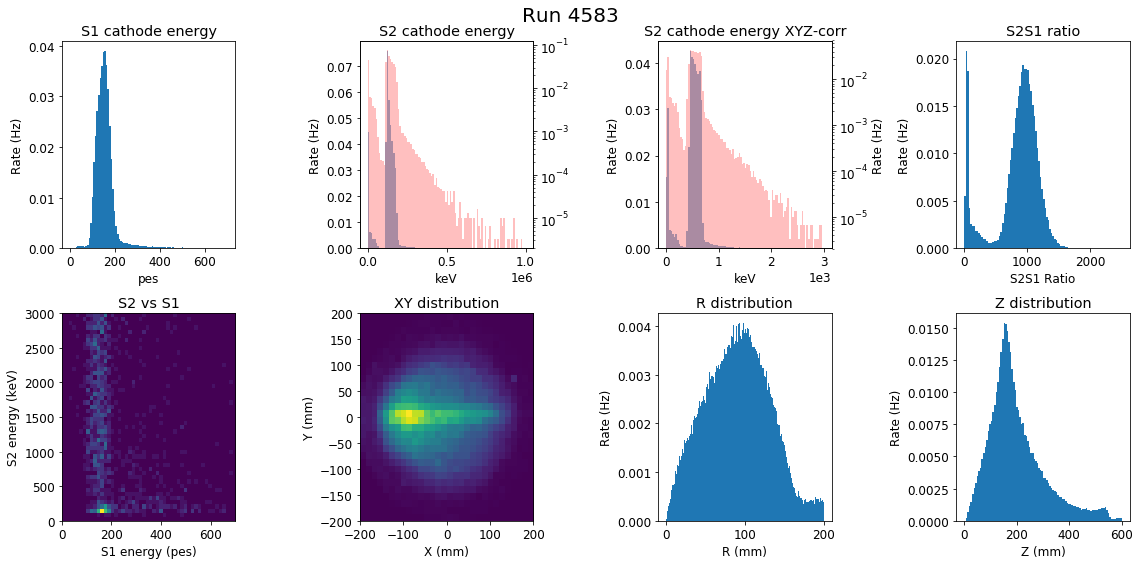

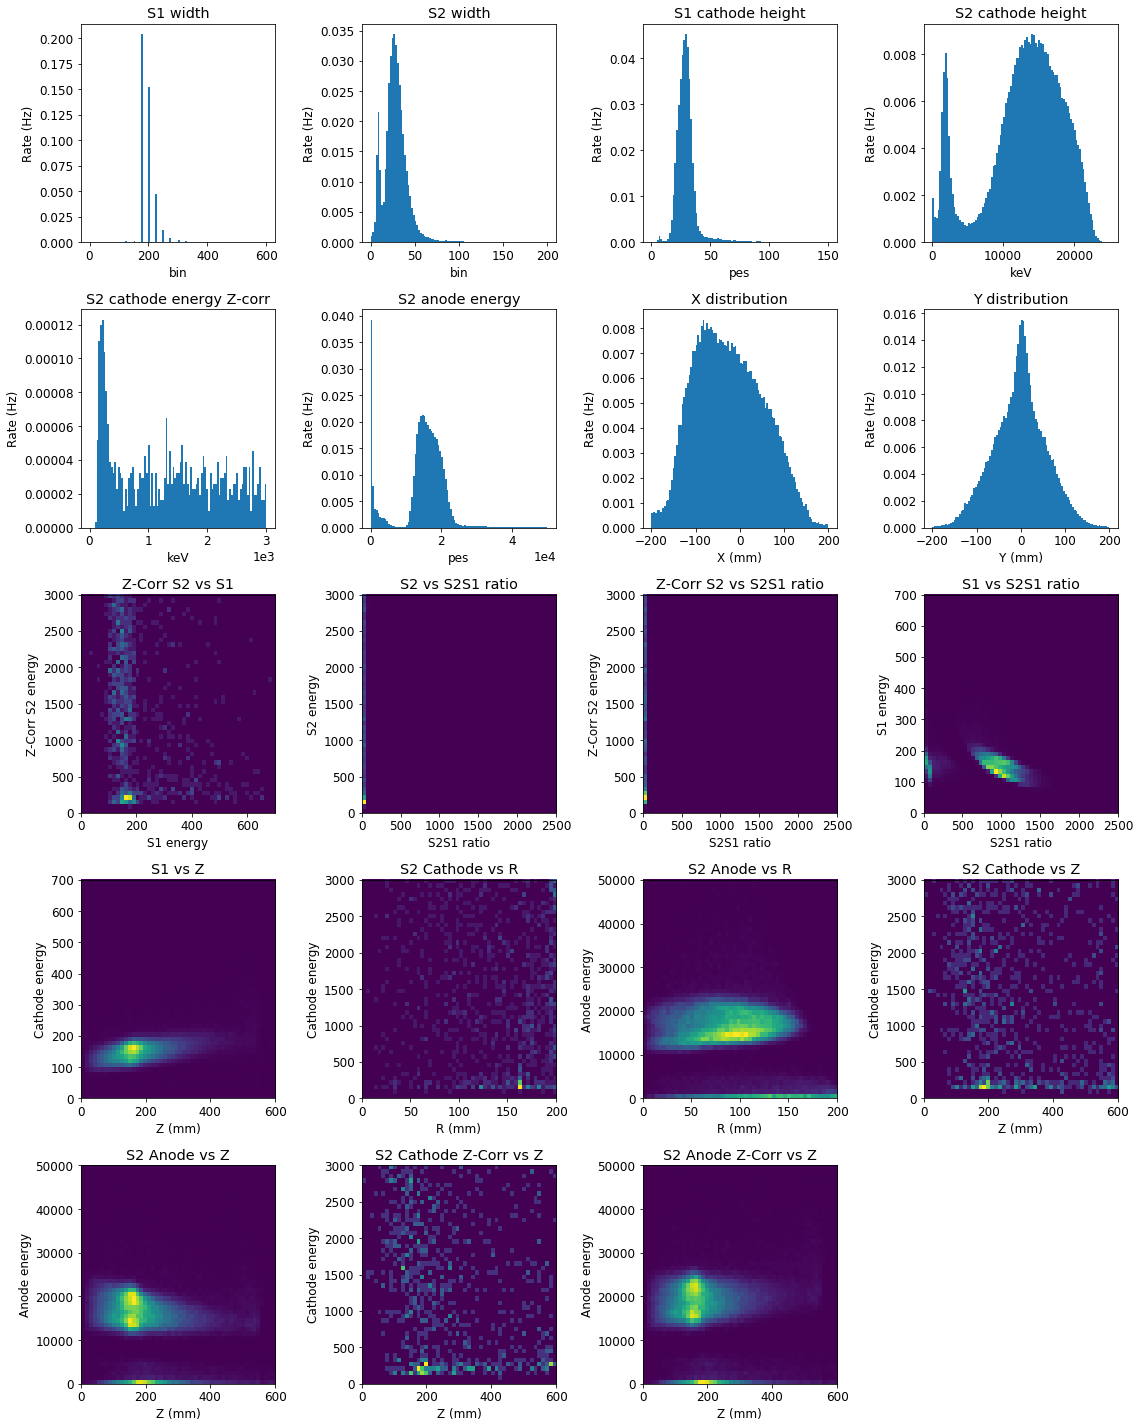

In [10]:
runNum = 4583
plot_var(runNum, kdst[runNum], ZCorr[runNum], XYCorr[runNum], limits, weight_val = runTime[runNum], fExtra = True)

#### Reference run with all distributions after basic cut

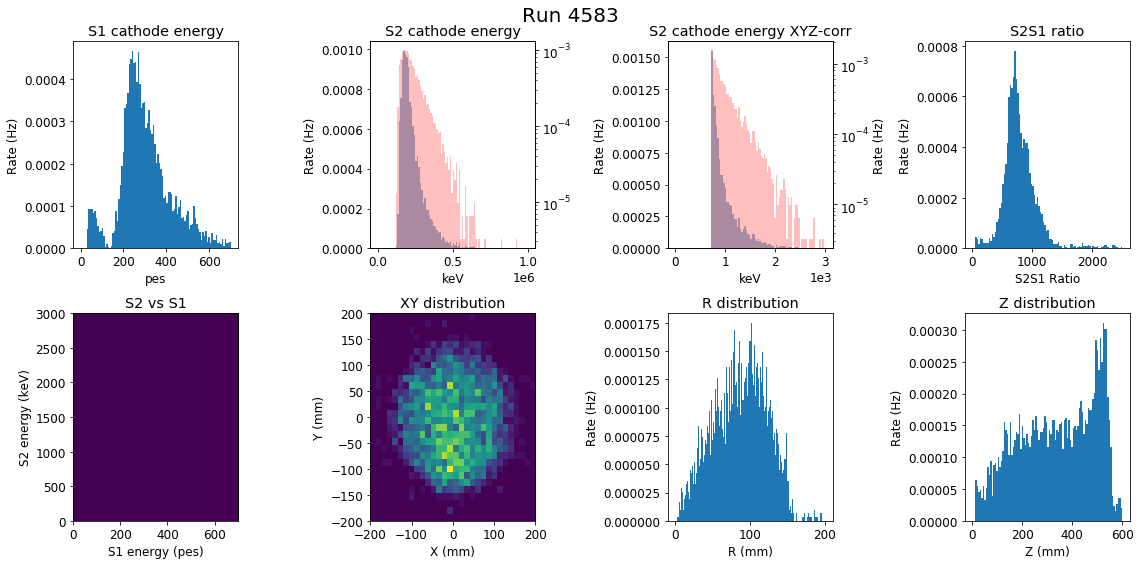

In [11]:
sel = kdst[runNum].S2e*ZCorr[runNum](kdst[runNum].Z.values).value*XYCorr[runNum](kdst[runNum].X.values, kdst[runNum].Y.values).value > 720.
sel = sel & (kdst[runNum].nS2 == 1)
plot_var(runNum, kdst[runNum][sel], ZCorr[runNum], XYCorr[runNum], limits, weight_val = runTime[runNum], fExtra = False)

#### Basic distributions for all runs

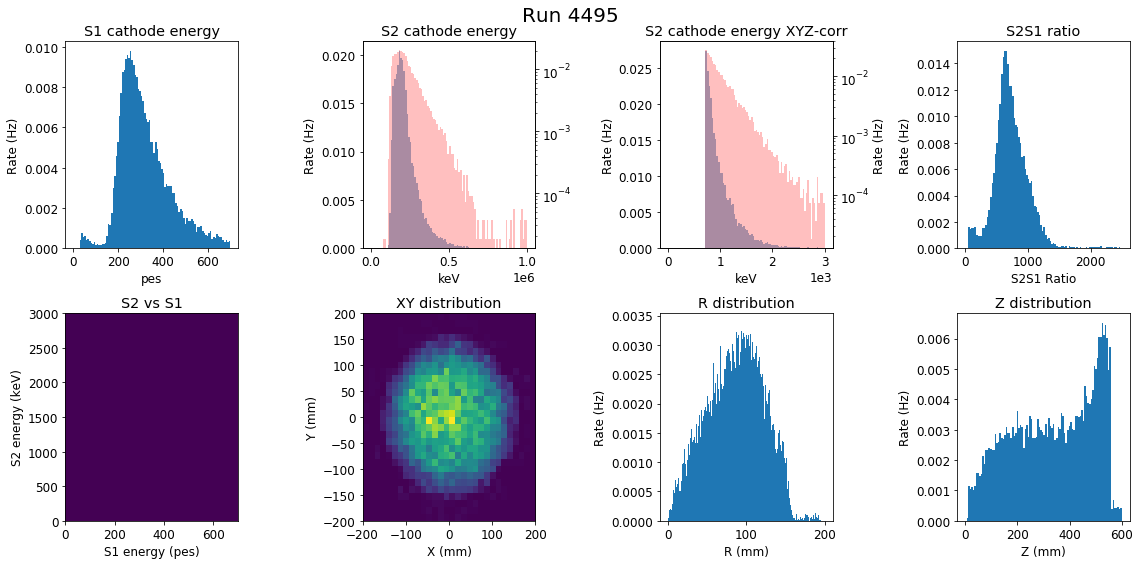

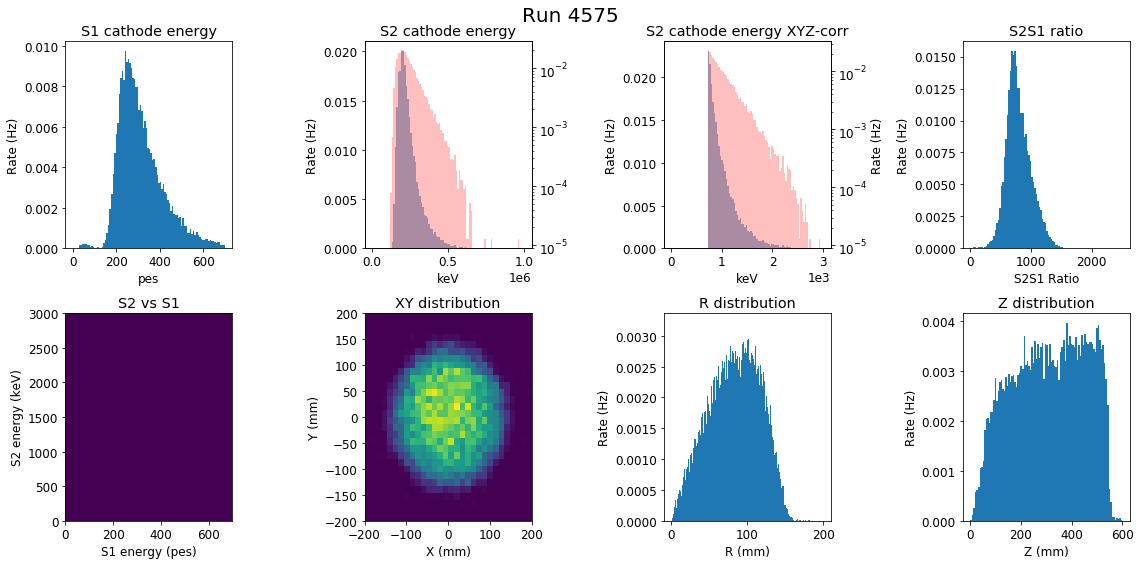

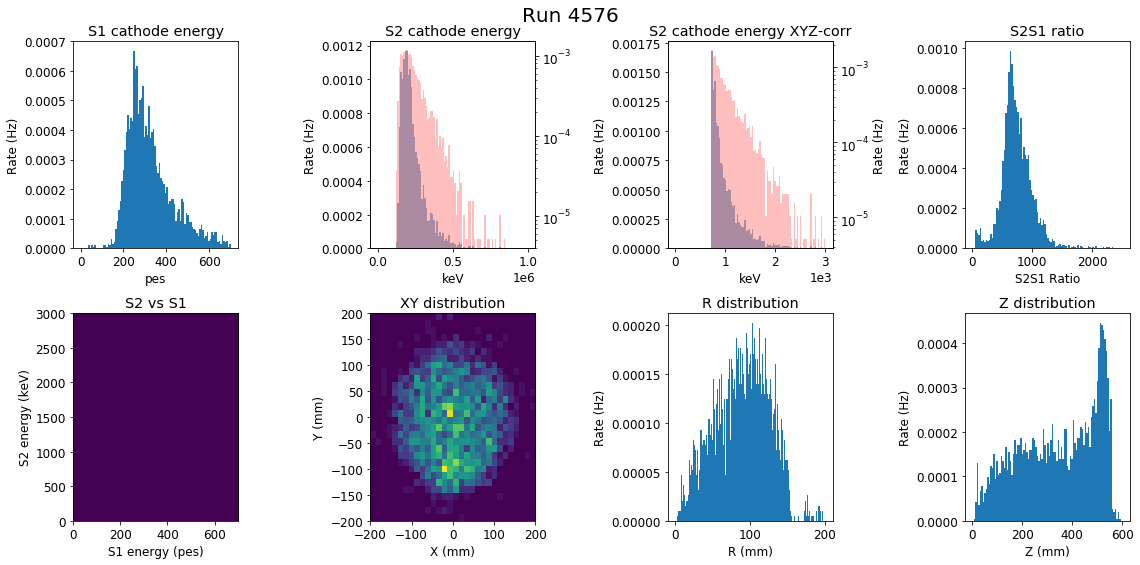

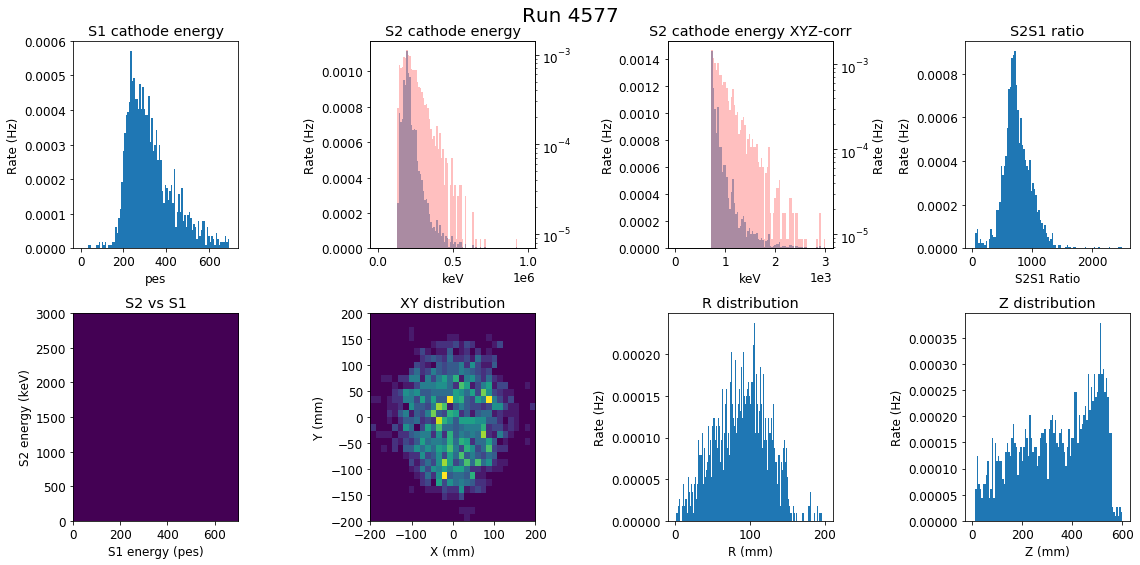

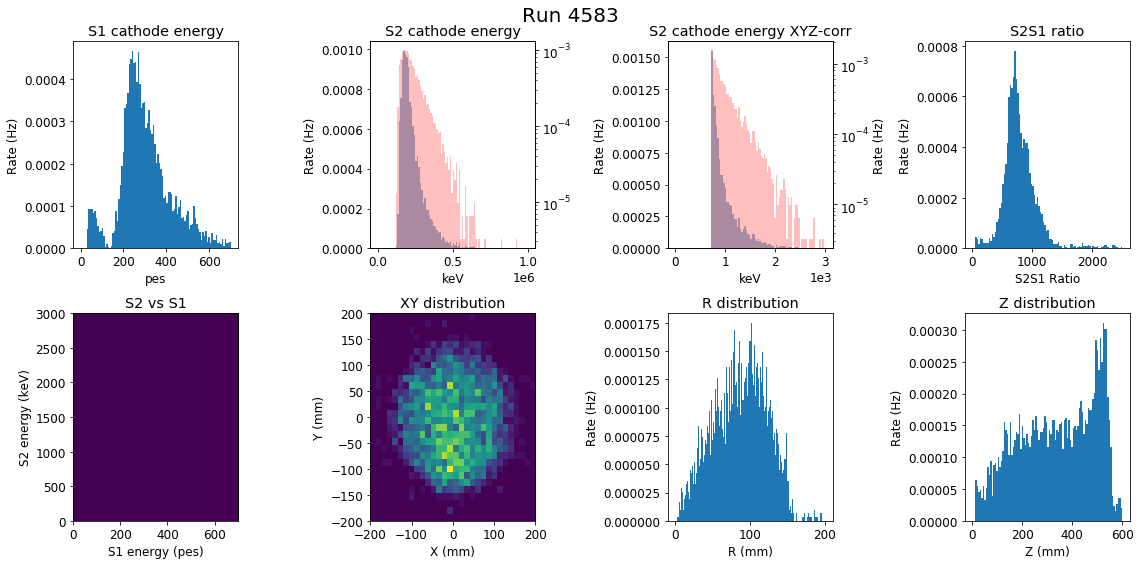

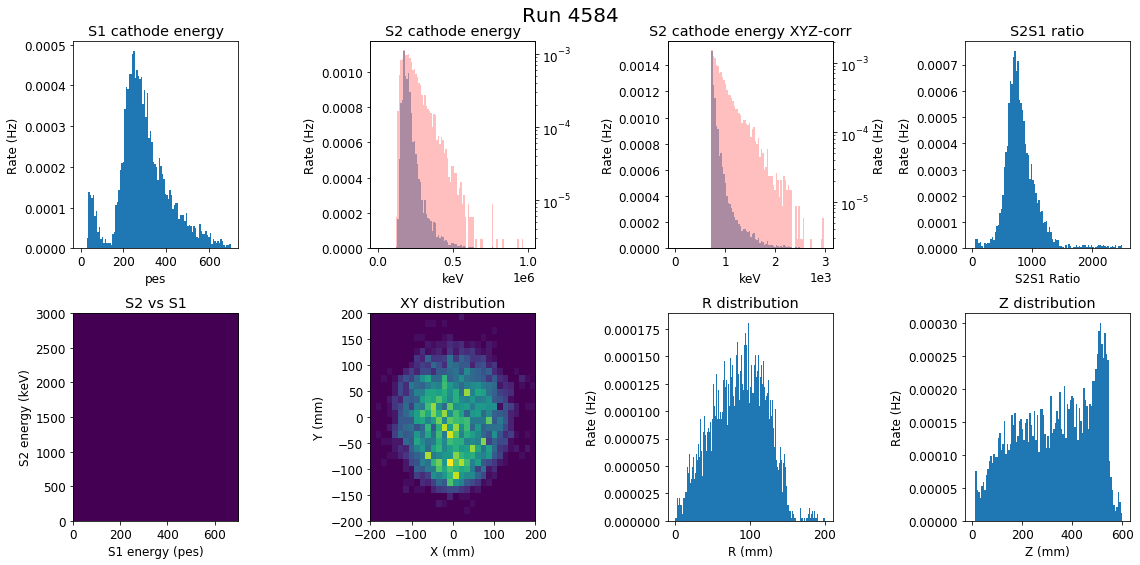

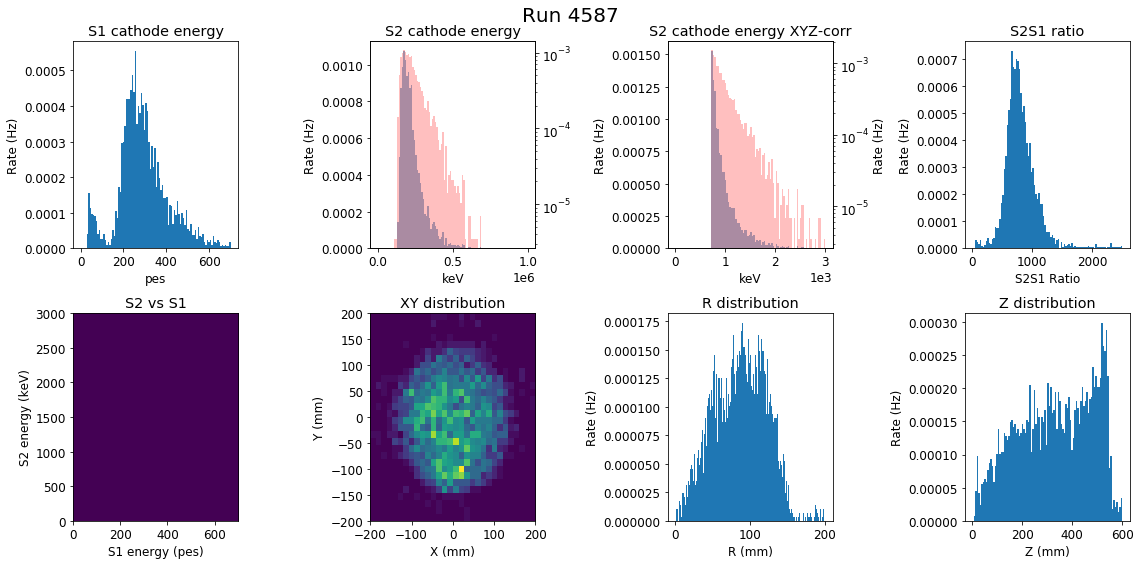

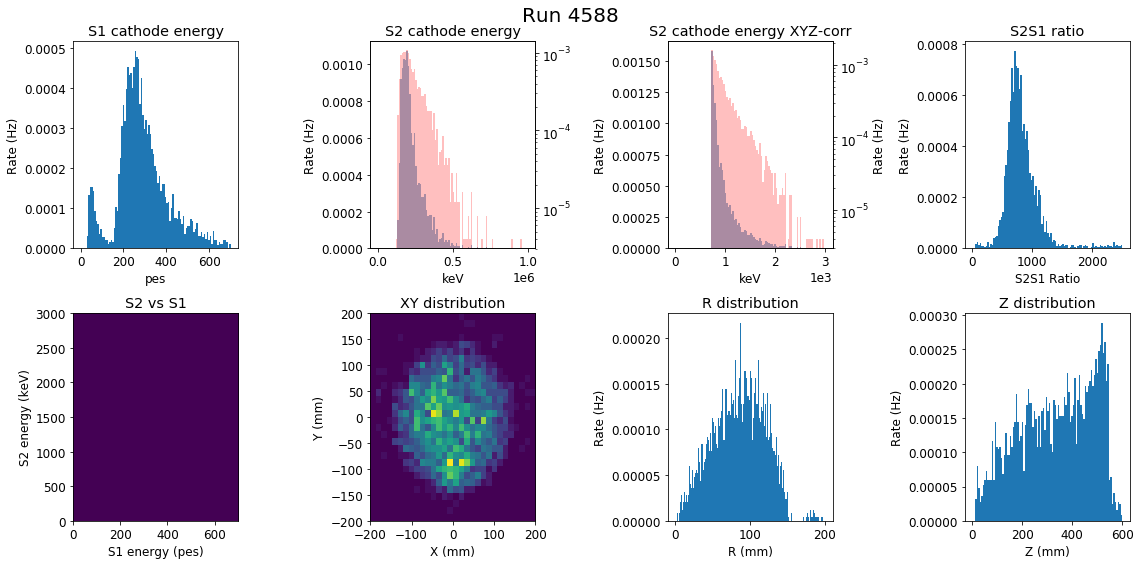

In [12]:
for run in run_numbers:
    sel = kdst[run].S2e*ZCorr[run](kdst[run].Z.values).value*XYCorr[run](kdst[run].X.values, kdst[run].Y.values).value > 720
    sel = sel & (kdst[run].nS2 == 1)
    plot_var(run, kdst[run][sel], ZCorr[run], XYCorr[run], limits, weight_val = runTime[run], fExtra = False)

## Radon disappearance (4 and 20 days after closing cold getter)

In [13]:
limits = {'s1e': [0., 700.], 's1w': [0, 600], 's1h': [0, 150], \
          's2e': [0, 3e3], 's2e_pes':[0,1e6], 's2w': [0., 200.], 's2h': [0., 25e3], 's2q':[0, 5e4], 'ratio': [0, 10], \
          'x': [-200, 200], 'y': [-200, 200], 'z': [0, 600], 'r': [0, 200]}

0.388225202296


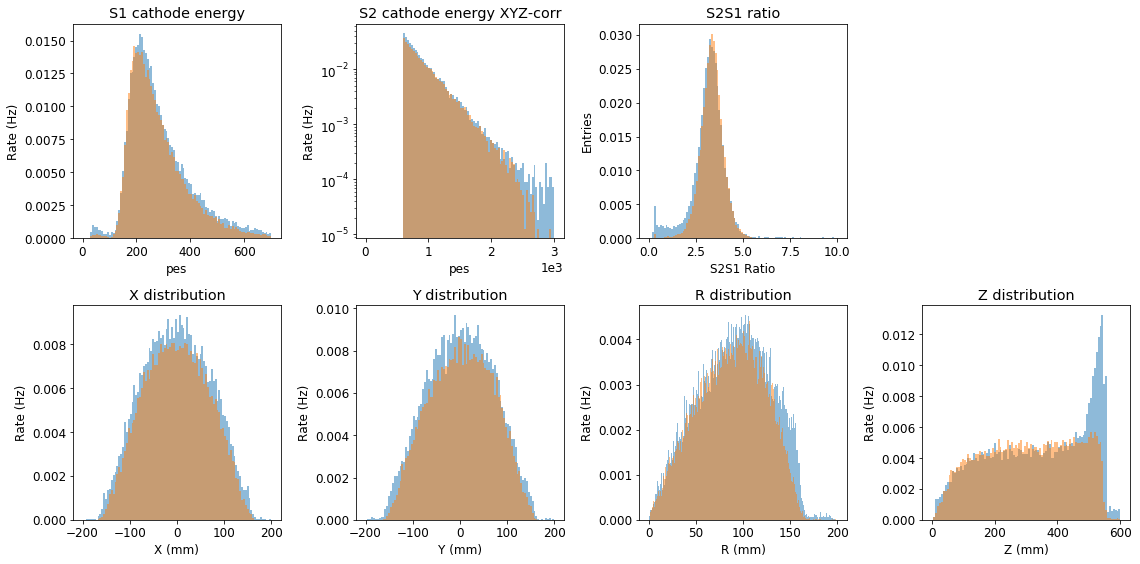

In [14]:
run1 = 4495
run2 = 4575

sel1 = corr_kdst[run1].S2e > 600
sel1 = sel1 & (corr_kdst[run1].nS2 == 1)
#sel1 = sel1 & coref.in_range(corr_kdst[run1].S2h, 500., 30e3)

sel2 = corr_kdst[run2].S2e > 600
sel2 = sel2 & (corr_kdst[run2].nS2 == 1)
#sel2 = sel2 & coref.in_range(corr_kdst[run2].S2h, 500., 30e3)

plot_var_same(corr_kdst[run1][sel1], corr_kdst[run2][sel2],\
              limits, weight_val_1 = runTime[run1], weight_val_2 = runTime[run2])

print(len(corr_kdst[run2][sel2])/runTime[run2])

In [15]:
print("Bg rate (Hz), 4 days after cold getter was closed: {}".format(len(kdst[run1])/runTime[run1]))
print("Bg rate (Hz), 20 days after cold getter was closed: {}".format(len(kdst[run2])/runTime[run2]))

Bg rate (Hz), 4 days after cold getter was closed: 1.5920671383750515
Bg rate (Hz), 20 days after cold getter was closed: 1.137570224752714


## Comparison with castle closed

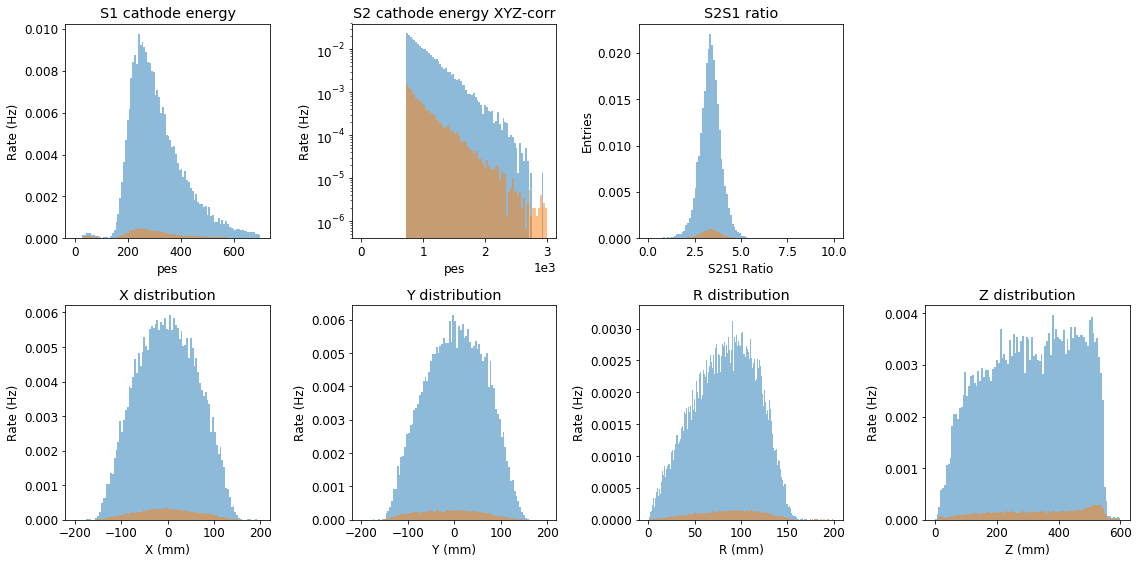

In [16]:
run1 = 4575
runs = [4576, 4577, 4583, 4584, 4587, 4588]
list_kdst = []
sum_runTime = 0

for run in runs:
    list_kdst.append(corr_kdst[run])
    sum_runTime += runTime[run]

sum_kdst = pd.concat(list_kdst)

sel1 = corr_kdst[run1].S2e > 720
sel1 = sel1 & (corr_kdst[run1].nS2 == 1)
    
sel2 = sum_kdst.S2e > 720
sel2 = sel2 & (sum_kdst.nS2 == 1)

plot_var_same(corr_kdst[run1][sel1], sum_kdst[sel2], limits, \
              weight_val_1 = runTime[run1], weight_val_2 = sum_runTime)

## General plots for castle closed

In [17]:
limits = {'s1e': [0., 700.], 's1w': [0, 600], 's1h': [0, 150], \
          's2e': [0, 3e3], 's2e_pes':[700,4e3], 's2w': [0., 200.], 's2h': [0., 25e3], 's2q':[0, 5e4], 'ratio': [0, 10], \
          'x': [-200, 200], 'y': [-200, 200], 'z': [0, 600], 'r': [0, 200]}

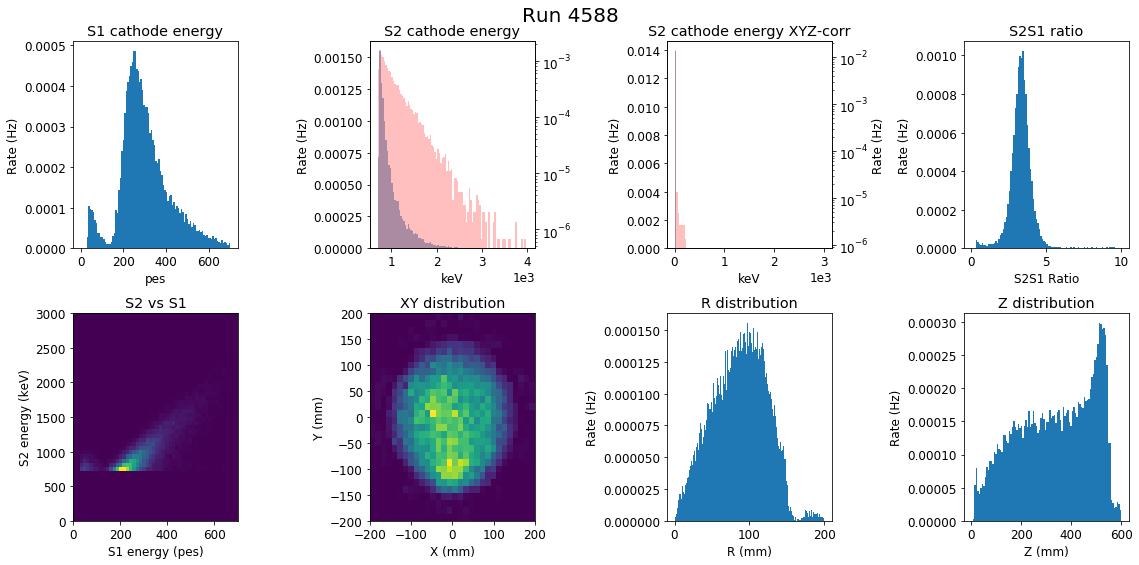

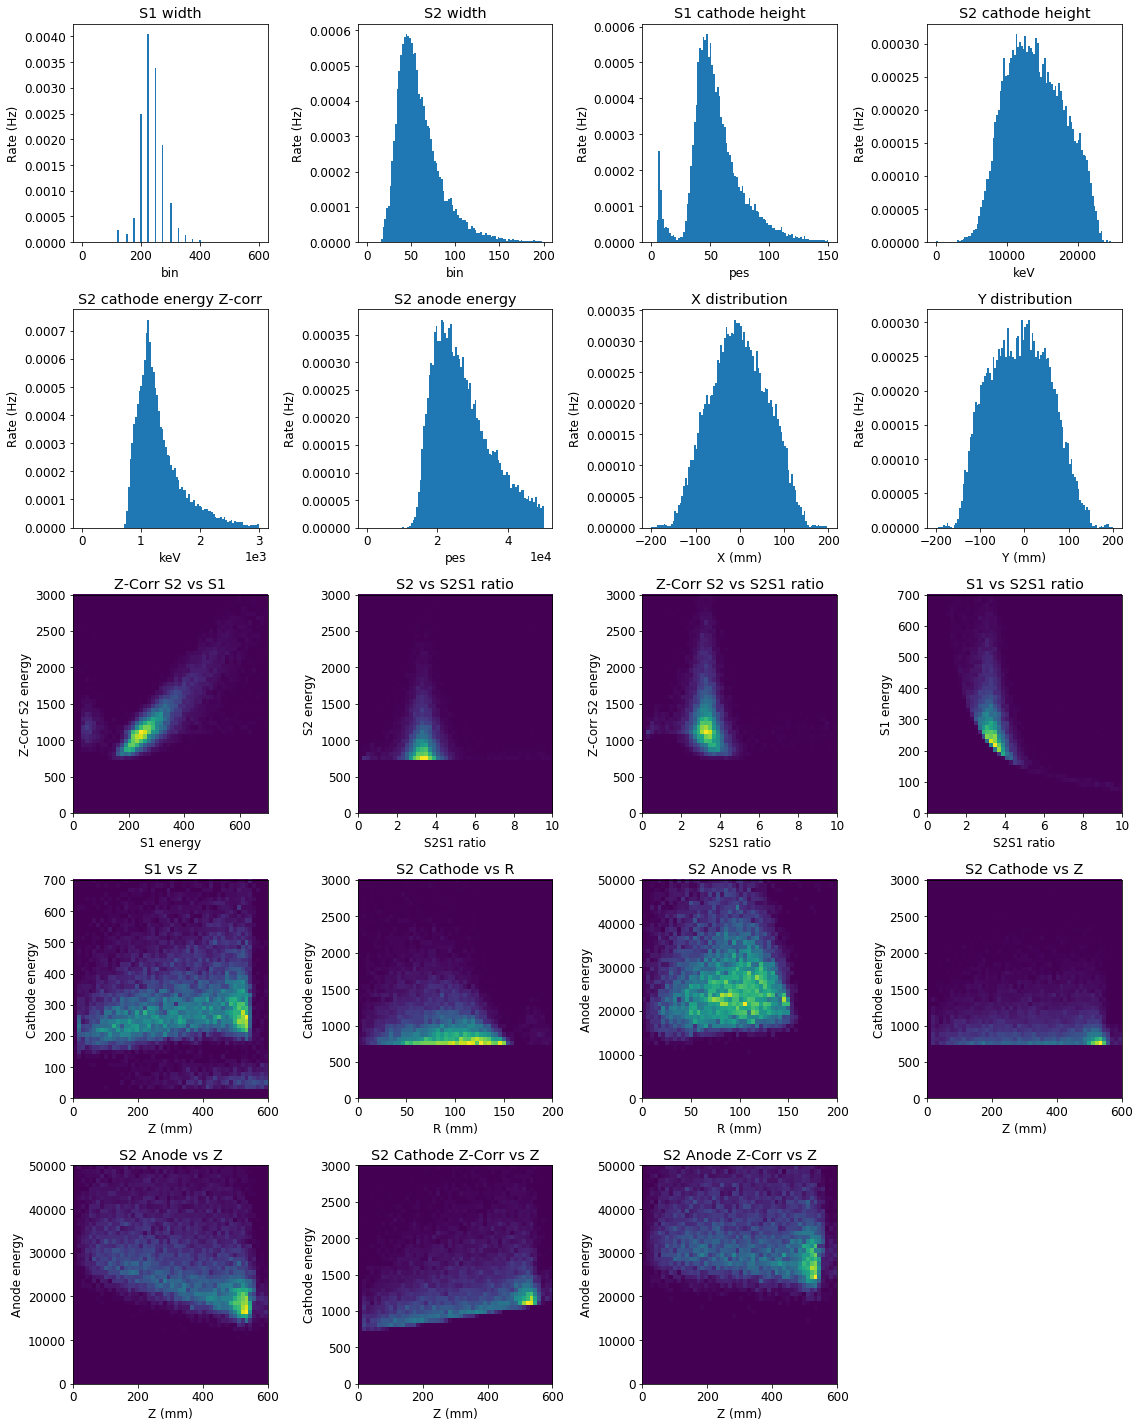

In [18]:
sel = sum_kdst.S2e > 720
sel = sel & (sum_kdst.nS2 == 1)
plot_var(run, sum_kdst[sel], ZCorr[run], XYCorr[run], limits, weight_val = sum_runTime, fExtra = True)

## Basic background estimation for several energies

In [19]:
def plot_bg(kDST, sigma, fwhm, emin, emax, step, t1, title, ax1):
    erange = np.arange(emin, emax, step)

    energy = []
    bg_rate = []
    entries = []
    
    for en in erange:
        energy.append(en)
        peak = en
        lim = [peak - sigma*(fwhm*peak)/235, peak + sigma*(fwhm*peak)/235]
        sel = coref.in_range(kDST.S2e, lim[0], lim[1])
        sel = sel & (kDST.nS2 == 1)
        bg_rate.append(len(kDST[sel])/t1)
        entries.append(len(kDST[sel]))
        
    energy = np.array(energy)
    bg_rate = np.array(bg_rate)
    entries = np.array(entries)
    
#    fig, ax1 = plt.subplots()
    ax1.errorbar(energy, bg_rate, yerr=np.sqrt(entries)/t1, fmt='o')
    ax2 = ax1.twinx()
    ax2.errorbar(energy, entries, yerr=np.sqrt(entries), fmt='o', c="red")

    ax1.set_ylim(np.min(bg_rate),np.max(bg_rate))
    ax1.set_xlabel('Energy (keV)')
    ax1.set_ylabel('Background rate (Hz)', color='blue')
    ax2.set_ylabel('Number of events', color='red')
    ax2.set_yscale("log")
    ax1.set_title(title)
    hist(kDST.S2e, int((emax-emin)/step), [emin, emax], new_figure = False, color="red", alpha = 0.25)

#    peak = emin
#    lim = [peak - sigma*(fwhm*peak)/235, kDST.S2e.max()]
    sel = kDST.S2e > emin
    sel = sel & (kDST.nS2 == 1)
    rate = [len(kDST[sel])/t1, np.sqrt(len(kDST[sel]))/t1]
    print("Bg rate for " + title + " = {0} +- {1}".format(rate[0], rate[1]))
    return rate

Bg rate for R4495, castle opened, 4 days without cold getter = 0.27251093401944926 +- 0.0022225989432806577
Bg rate for R4575, castle opened, 20 days without cold getter = 0.24228788330068918 +- 0.0017592231255885856
Bg rate for Run 4576-4588, castle closed = 0.01242710373543348 +- 9.108567243750428e-05


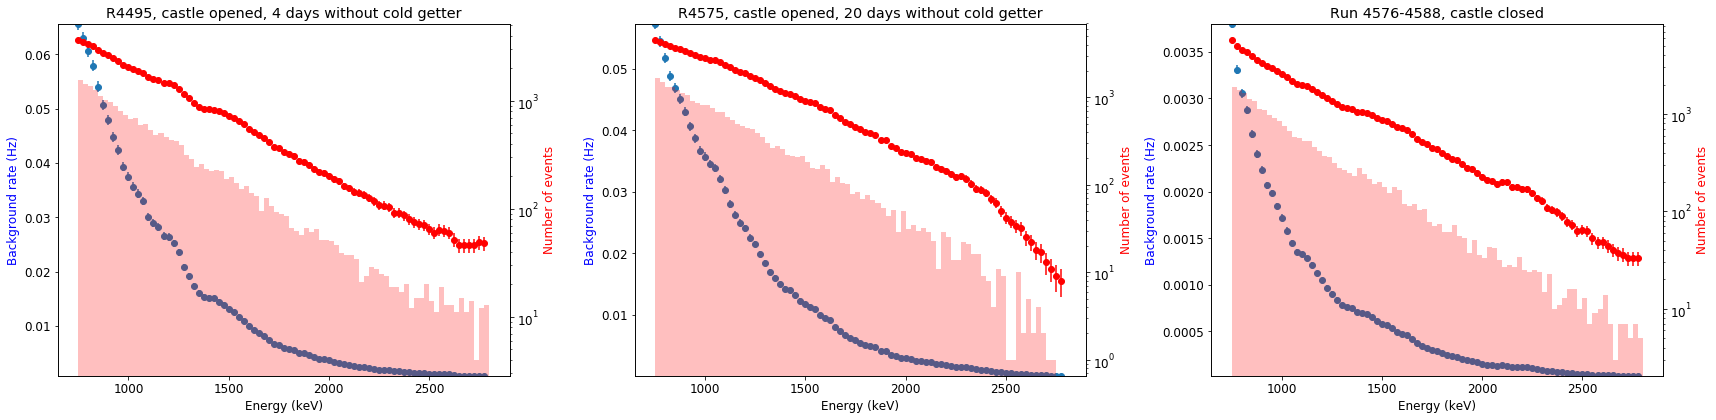

In [20]:
fig, ax = plt.subplots(1,3, figsize=(24,6))

title = "R4495, castle opened, 4 days without cold getter"
runNo = 4495
plot_bg(corr_kdst[runNo], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[0])

title = "R4575, castle opened, 20 days without cold getter"
runNo = 4575
plot_bg(corr_kdst[runNo], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[1])

title = "Run 4576-4588, castle closed"
rate = plot_bg(sum_kdst, 3., 4., 750, 2800, 25, sum_runTime, title, ax[2])

fig.tight_layout()

## Background estimation along time

In [21]:
def c_expo(x, const, slope, bg):
    return const*np.exp(-x/slope) + bg

Bg rate for 08-03 18:53:28 --- 08-06 00:34:19 = 0.014654555490701942 +- 0.000275375960668329
Bg rate for 08-06 00:38:37 --- 08-07 08:13:54 = 0.013322539877585738 +- 0.0003422793609281763
Bg rate for 08-07 21:07:52 --- 08-11 10:57:20 = 0.011658140041566286 +- 0.00019424838363383165
Bg rate for 08-11 10:59:58 --- 08-15 10:35:06 = 0.01212120246955204 +- 0.00018768329125247647
Bg rate for 08-15 11:14:59 --- 08-18 19:17:05 = 0.012262006148266287 +- 0.00020629547918593846
Bg rate for 08-18 19:22:40 --- 08-21 16:44:05 = 0.011858928731029582 +- 0.00021793463496130506


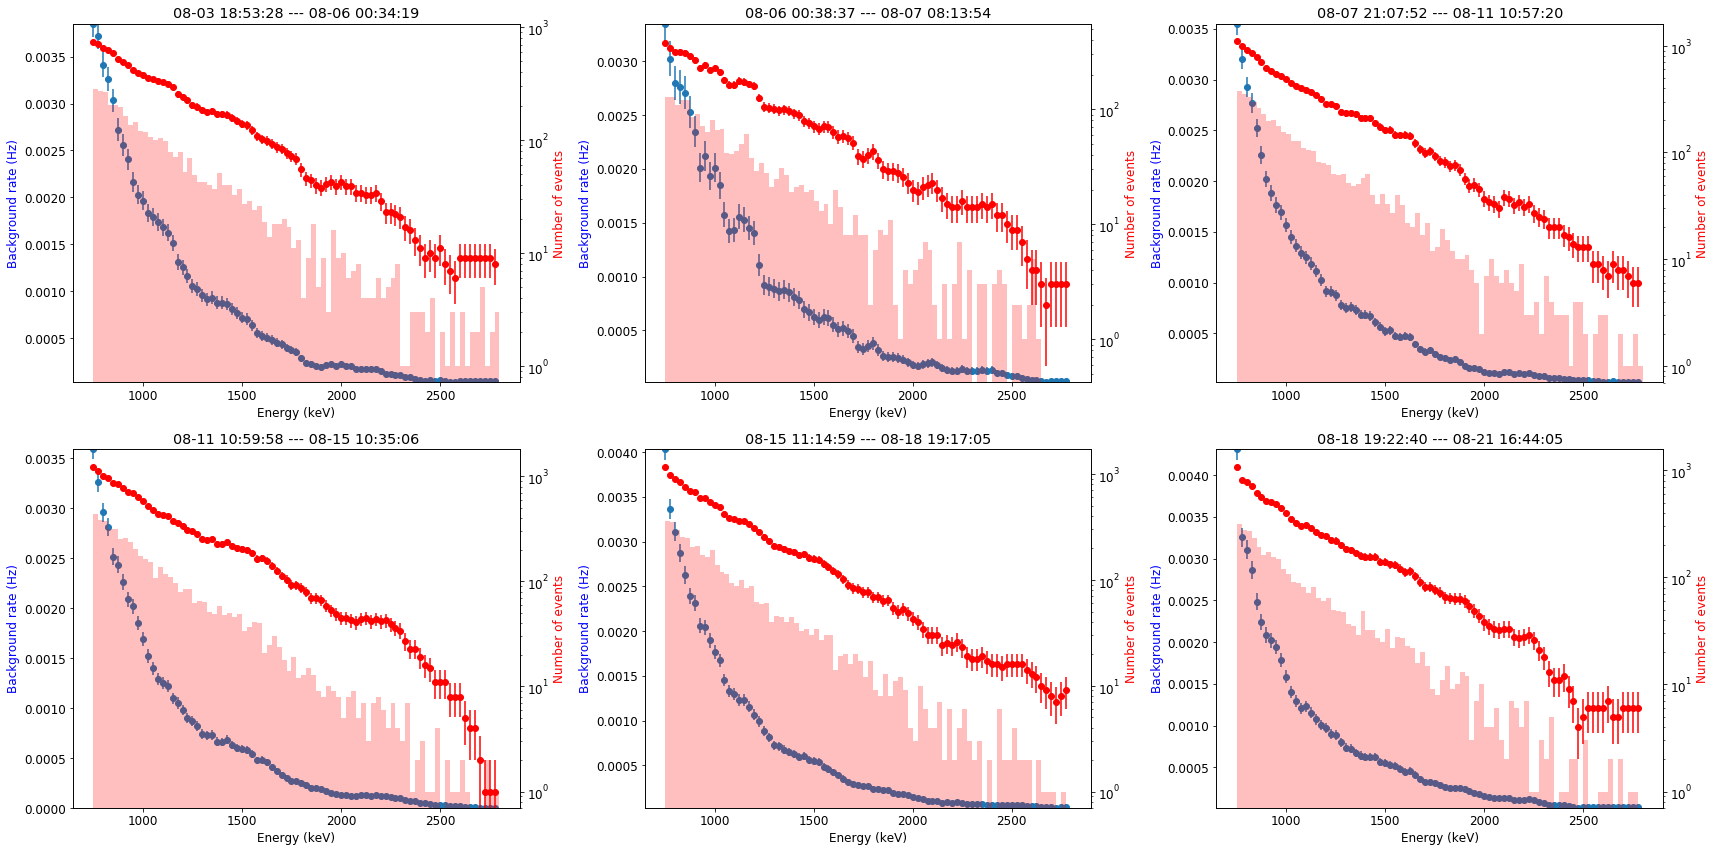

In [38]:
runs = [4576, 4577, 4583, 4584, 4587, 4588]
tot_rate = []
trange = []
n_row = 3
nrows = len(runs)//n_row

if len(runs)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, run in enumerate(runs):
    title = datetime.datetime.fromtimestamp(int(corr_kdst[run].time.min())).strftime('%m-%d %H:%M:%S') + " --- " + datetime.datetime.fromtimestamp(int(corr_kdst[run].time.max())).strftime('%m-%d %H:%M:%S') 
    trange.append(corr_kdst[run].time.mean())
    tot_rate.append(plot_bg(corr_kdst[run], 3., 4., 750, 2800, 25, runTime[run], title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

Radon disappearance lifetime: 130939.96344389846 s


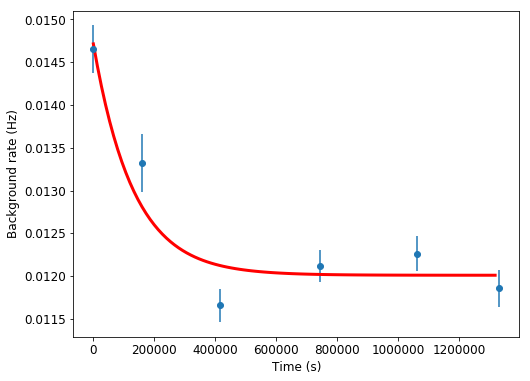

In [40]:
rate = list([x[0] for x in tot_rate])
rate_err = list([x[1] for x in tot_rate])
plt.errorbar(trange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Time (s)")
plt.ylabel("Background rate (Hz)")

trange = np.array(trange)
trange = trange - trange[0]

seed = (rate[0], trange[-1]/np.log(rate[0]/rate[-1]), rate[-1])
bound = ([0., trange[-1]/np.log(rate[0]/rate[-1])*0.01, 0.], [1., trange[-1]/np.log(rate[0]/rate[-1])*100., 1.])
f    = fitf.fit(c_expo, trange, np.array(rate), seed, fit_range=[trange[0],trange[-1]], sigma=np.array(rate_err), bounds=bound)

times = np.arange(trange[0], trange[-1], (trange[-1]-trange[0])/100)
plt.plot(times, f.fn(times), fitOpt, lw=3)

print("Radon disappearance lifetime: {} s".format(f.values[1]))


## Y dependance

Bg rate for Y = [-200.000000,-166.666667) = 1.7358154997382105e-05 +- 3.404214271216133e-06
Bg rate for Y = [-166.666667,-133.333333) = 0.0001568910163224921 +- 1.0234441435704741e-05
Bg rate for Y = [-133.333333,-100.000000) = 0.0010641884256087336 +- 2.6654735210823116e-05
Bg rate for Y = [-100.000000,-66.666667) = 0.0016864115201302768 +- 3.355419987228018e-05
Bg rate for Y = [-66.666667,-33.333333) = 0.0019294256900936261 +- 3.5890469157282546e-05
Bg rate for Y = [-33.333333,0.000000) = 0.002018219329118696 +- 3.6707033455956714e-05
Bg rate for Y = [0.000000,33.333333) = 0.0020275660279634403 +- 3.679193336589702e-05
Bg rate for Y = [33.333333,66.666667) = 0.0017999071489593135 +- 3.4664916465483064e-05
Bg rate for Y = [66.666667,100.000000) = 0.001154984928671963 +- 2.776855402701204e-05
Bg rate for Y = [100.000000,133.333333) = 0.00046800256358326363 +- 1.76762128708552e-05
Bg rate for Y = [133.333333,166.666667) = 8.745839633296368e-05 +- 7.641275566517921e-06
Bg rate for Y = [1

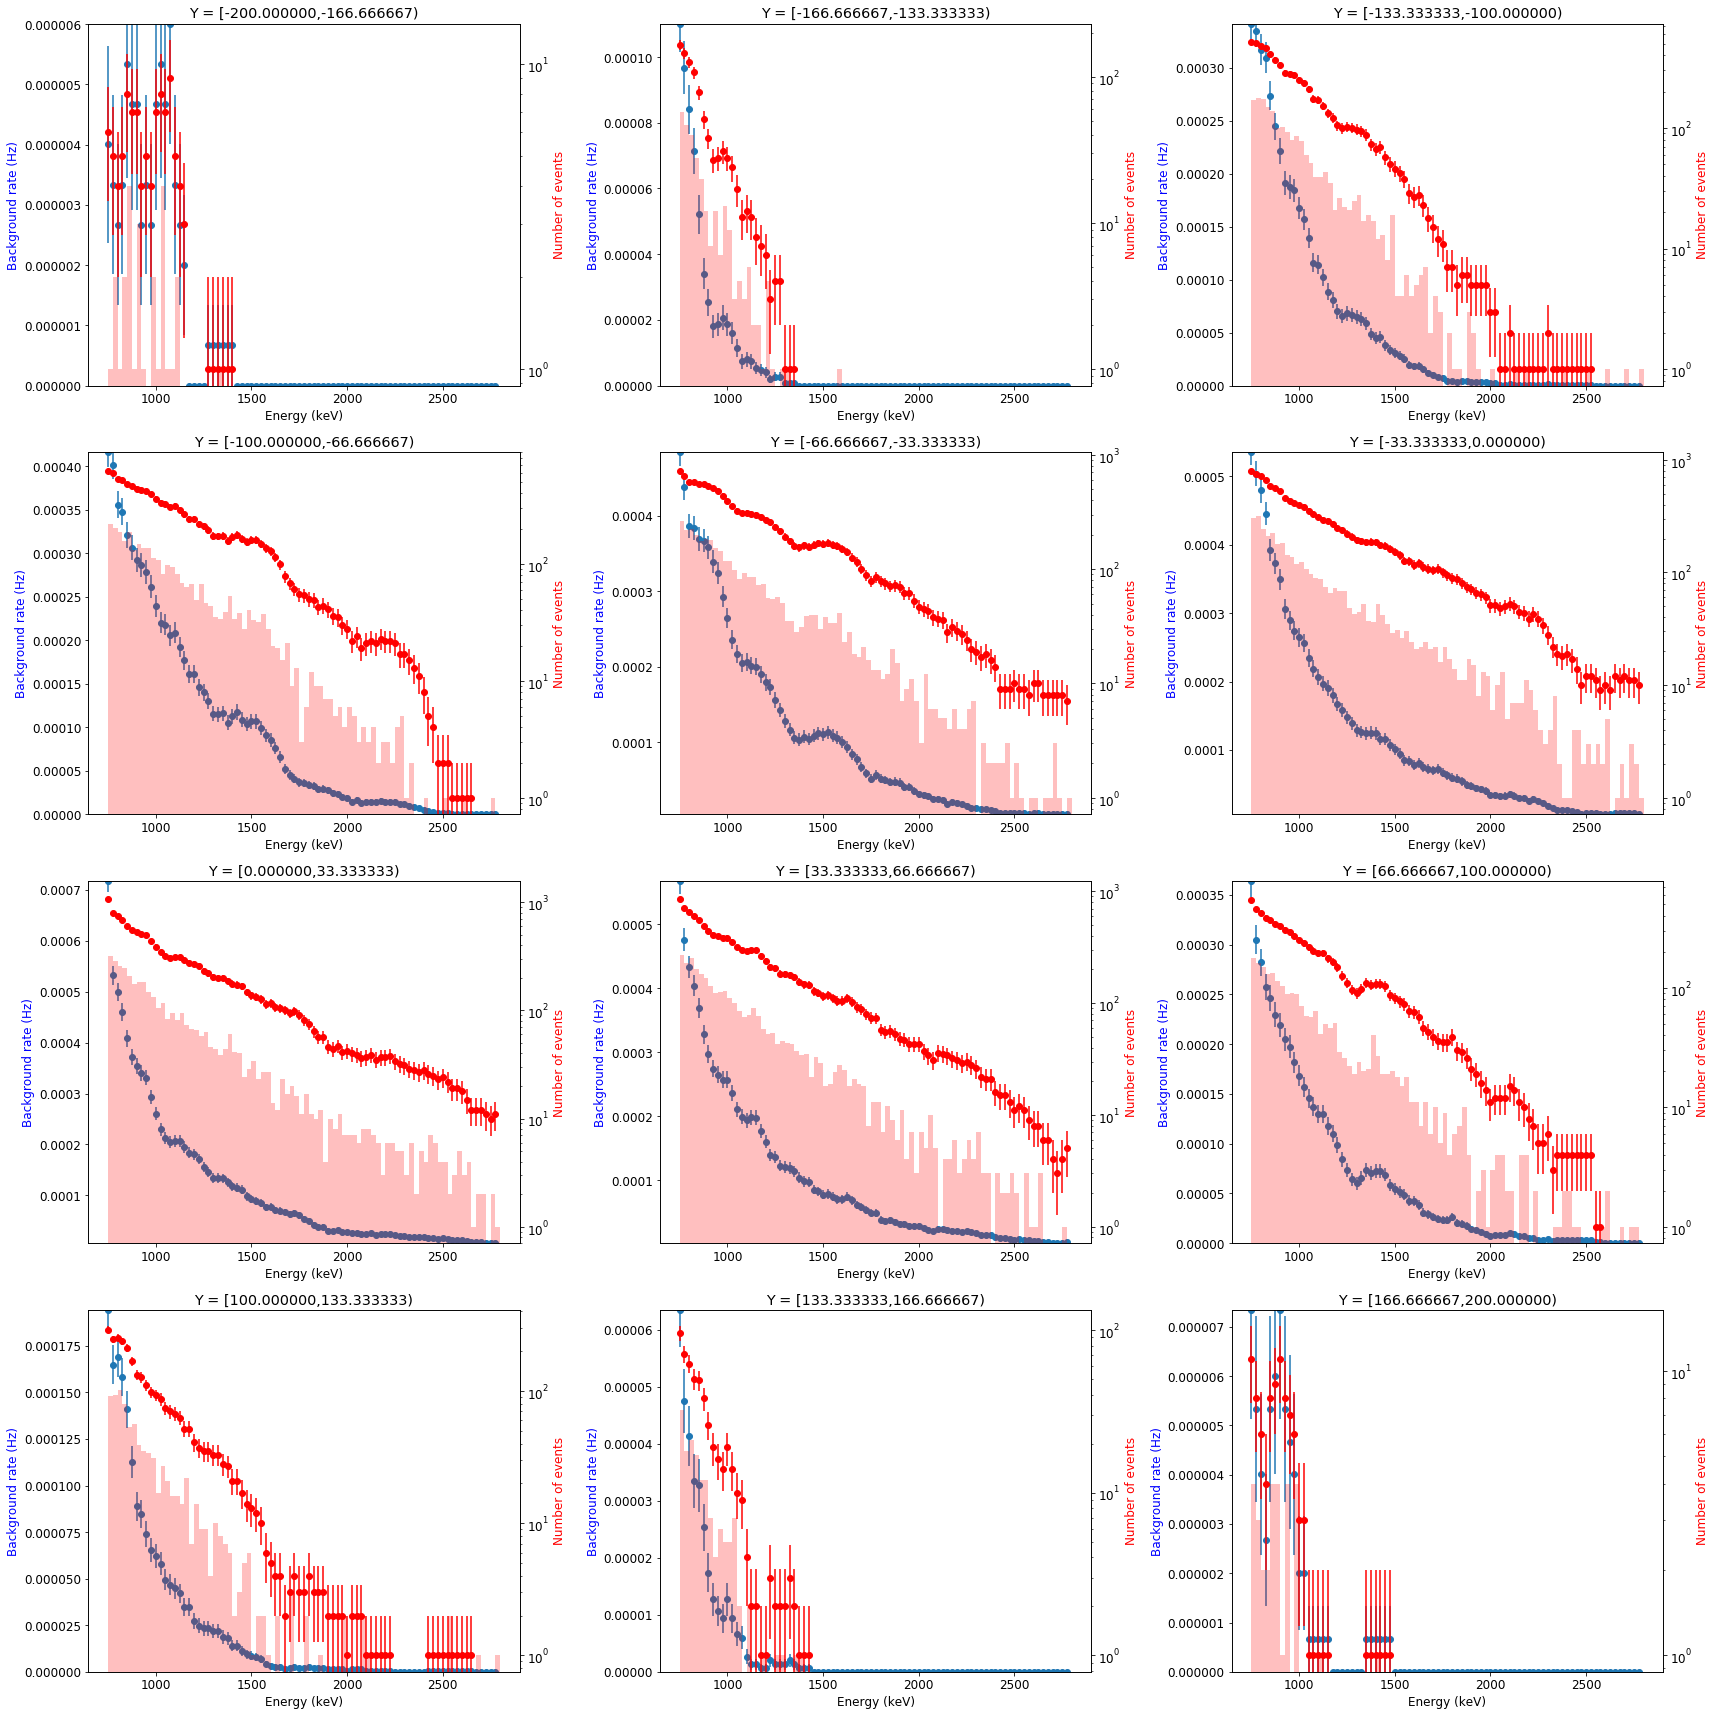

In [41]:
var_min = -200
var_max = 200
step = (var_max - var_min)/12
yrange = np.arange(var_min, var_max, step)

tot_rate_y = []

n_row = 3
nrows = len(yrange)//n_row

if len(trange)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, y in enumerate(yrange):
    title = "Y = [{0:2f},{1:2f})".format(y, y+step)
    sel = coref.in_range(sum_kdst.Y, y, y+step)
    tot_rate_y.append(plot_bg(sum_kdst[sel], 3., 4., 750, 2800, 25, sum_runTime, title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

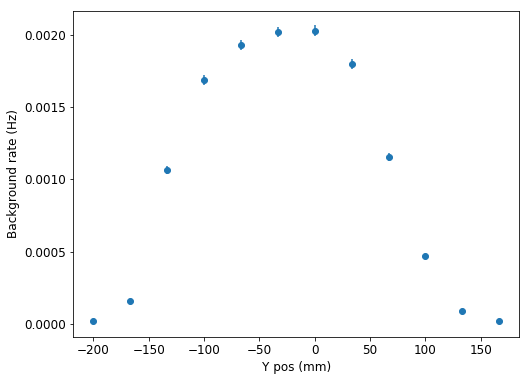

In [42]:
rate = list([x[0] for x in tot_rate_y])
rate_err = list([x[1] for x in tot_rate_y])
plt.errorbar(yrange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Y pos (mm)")
plt.ylabel("Background rate (Hz)")

## Cathode selection

Bg rate for R4495, castle opened, 4 days without cold getter = 0.058642511245454554 +- 0.001031039769473486
Bg rate for R4575, castle opened, 20 days without cold getter = 0.029519574984599995 +- 0.0006140590375785896
Bg rate for Run 4576-4588, castle closed = 0.0024034368457913685 +- 4.005728076318947e-05


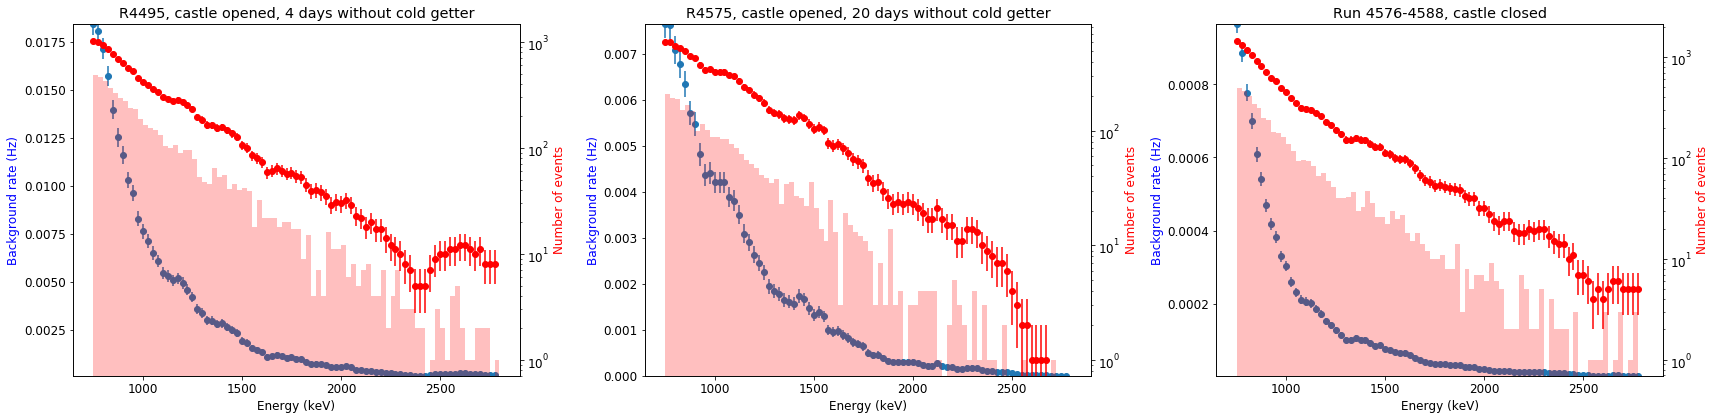

In [43]:
fig, ax = plt.subplots(1,3, figsize=(24,6))

title = "R4495, castle opened, 4 days without cold getter"
runNo = 4495
sel = coref.in_range(corr_kdst[runNo].Z, 490, 575) 
plot_bg(corr_kdst[runNo][sel], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[0])

title = "R4575, castle opened, 20 days without cold getter"
runNo = 4575
sel = coref.in_range(corr_kdst[runNo].Z, 490, 575) 
plot_bg(corr_kdst[runNo][sel], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[1])

title = "Run 4576-4588, castle closed"
sel = coref.in_range(sum_kdst.Z, 490, 575) 
rate = plot_bg(sum_kdst[sel], 3., 4., 750, 2800, 25, sum_runTime, title, ax[2])

fig.tight_layout()

#### Time dependance

Bg rate for 08-03 18:53:28 --- 08-06 00:34:19 = 0.003435955100927292 +- 0.00013334091789440368
Bg rate for 08-06 00:38:37 --- 08-07 08:13:54 = 0.0024974266173164025 +- 0.0001481950051058113
Bg rate for 08-07 21:07:52 --- 08-11 10:57:20 = 0.0024177208803581388 +- 8.845978109804459e-05
Bg rate for 08-11 10:59:58 --- 08-15 10:35:06 = 0.0022405771047769416 +- 8.069241340021378e-05
Bg rate for 08-15 11:14:59 --- 08-18 19:17:05 = 0.002103248153368064 +- 8.543861589980768e-05
Bg rate for 08-18 19:22:40 --- 08-21 16:44:05 = 0.0021146620634865314 +- 9.202885378754361e-05


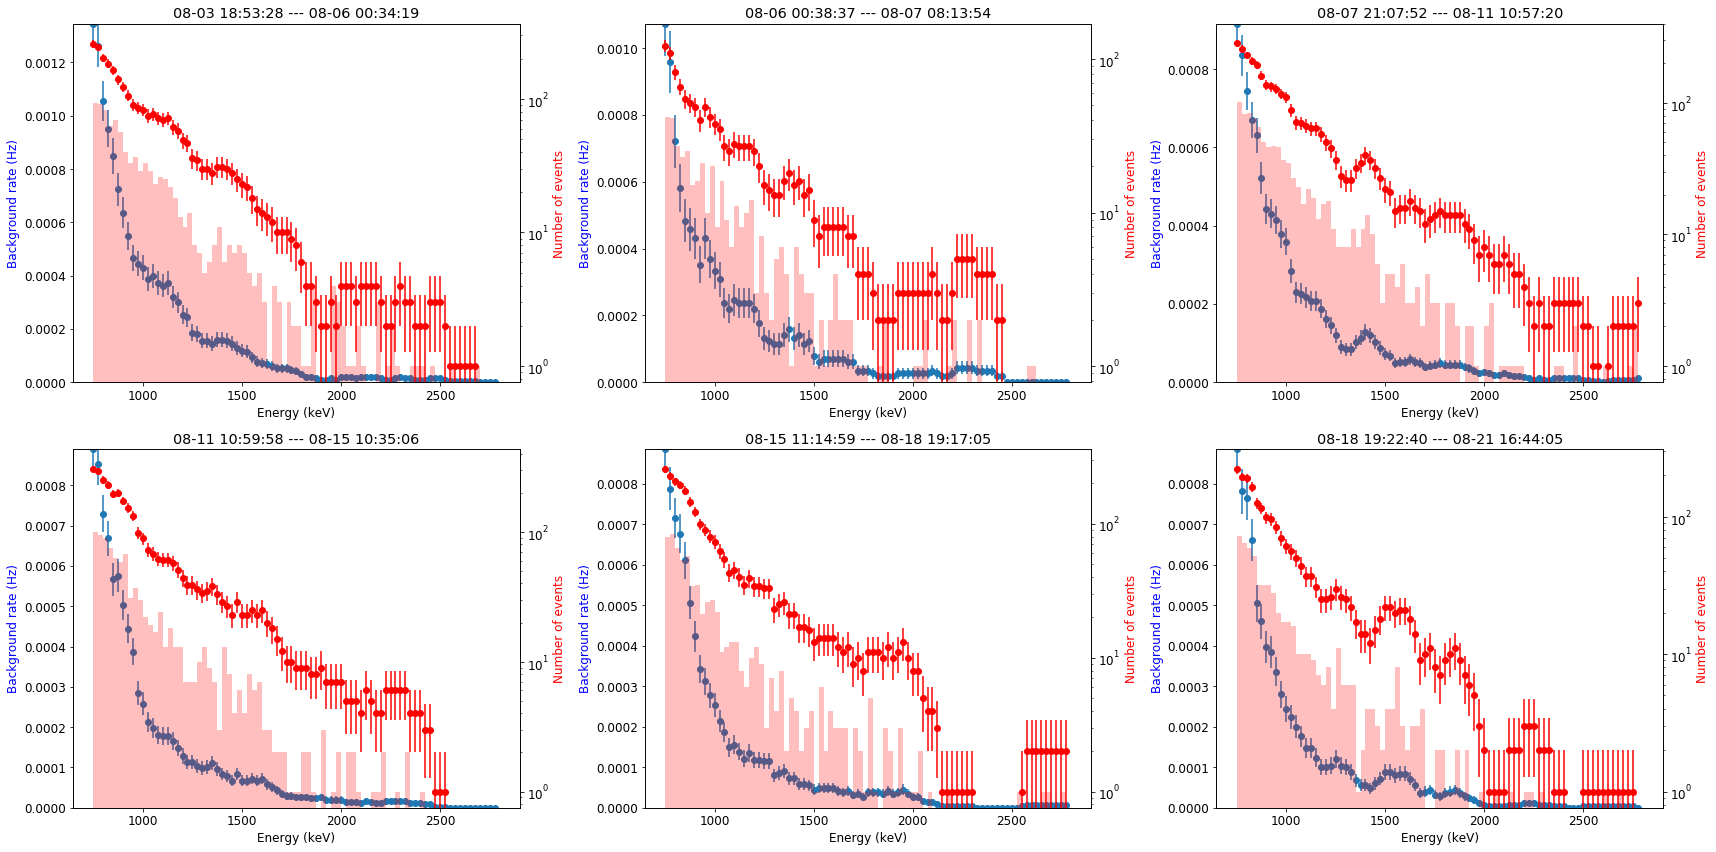

In [44]:
runs = [4576, 4577, 4583, 4584, 4587, 4588]
tot_rate = []
trange = []
n_row = 3
nrows = len(runs)//n_row

if len(runs)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, run in enumerate(runs):
    title = datetime.datetime.fromtimestamp(int(corr_kdst[run].time.min())).strftime('%m-%d %H:%M:%S') + " --- " + datetime.datetime.fromtimestamp(int(corr_kdst[run].time.max())).strftime('%m-%d %H:%M:%S') 
    trange.append(corr_kdst[run].time.mean())
    sel = coref.in_range(corr_kdst[run].Z, 490, 575) 
    tot_rate.append(plot_bg(corr_kdst[run][sel], 3., 4., 750, 2800, 25, runTime[run], title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

Radon disappearance lifetime: 185235.79393590087 s


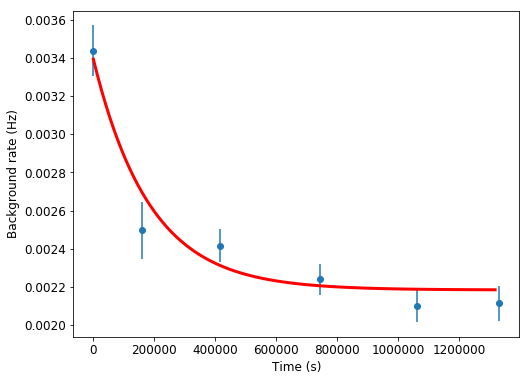

In [46]:
rate = list([x[0] for x in tot_rate])
rate_err = list([x[1] for x in tot_rate])
plt.errorbar(trange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Time (s)")
plt.ylabel("Background rate (Hz)")

trange = np.array(trange)
trange = trange - trange[0]

seed = (rate[0], trange[-1]/np.log(rate[0]/rate[-1]), rate[-1])
bound = ([0., trange[-1]/np.log(rate[0]/rate[-1])*0.01, 0.], [1., trange[-1]/np.log(rate[0]/rate[-1])*100., 1.])
f    = fitf.fit(c_expo, trange, np.array(rate), seed, fit_range=[trange[0],trange[-1]], sigma=np.array(rate_err), bounds=bound)

times = np.arange(trange[0], trange[-1], (trange[-1]-trange[0])/100)
plt.plot(times, f.fn(times), fitOpt, lw=3)

print("Radon disappearance lifetime: {} s".format(f.values[1]))


#### Y dependance

Bg rate for Y = [-200.000000,-166.666667) = 0.0 +- 0.0
Bg rate for Y = [-166.666667,-133.333333) = 3.404868864871105e-05 +- 4.767770060206066e-06
Bg rate for Y = [-133.333333,-100.000000) = 0.00015555577363038578 +- 1.0190797563363647e-05
Bg rate for Y = [-100.000000,-66.666667) = 0.00027706285861206053 +- 1.3600480822673865e-05
Bg rate for Y = [-66.666667,-33.333333) = 0.0003645212549450242 +- 1.5600069579696862e-05
Bg rate for Y = [-33.333333,0.000000) = 0.0003945642155174163 +- 1.623020310002761e-05
Bg rate for Y = [0.000000,33.333333) = 0.0004099195064766389 +- 1.6543004947329846e-05
Bg rate for Y = [33.333333,66.666667) = 0.0003878880020568847 +- 1.609230592709098e-05
Bg rate for Y = [66.666667,100.000000) = 0.00023633795650281788 +- 1.2561220666952075e-05
Bg rate for Y = [100.000000,133.333333) = 0.00011216038613693052 +- 8.653361656985075e-06
Bg rate for Y = [133.333333,166.666667) = 3.137820326449842e-05 +- 4.576981352395269e-06
Bg rate for Y = [166.666667,200.000000) = 0.0 +- 

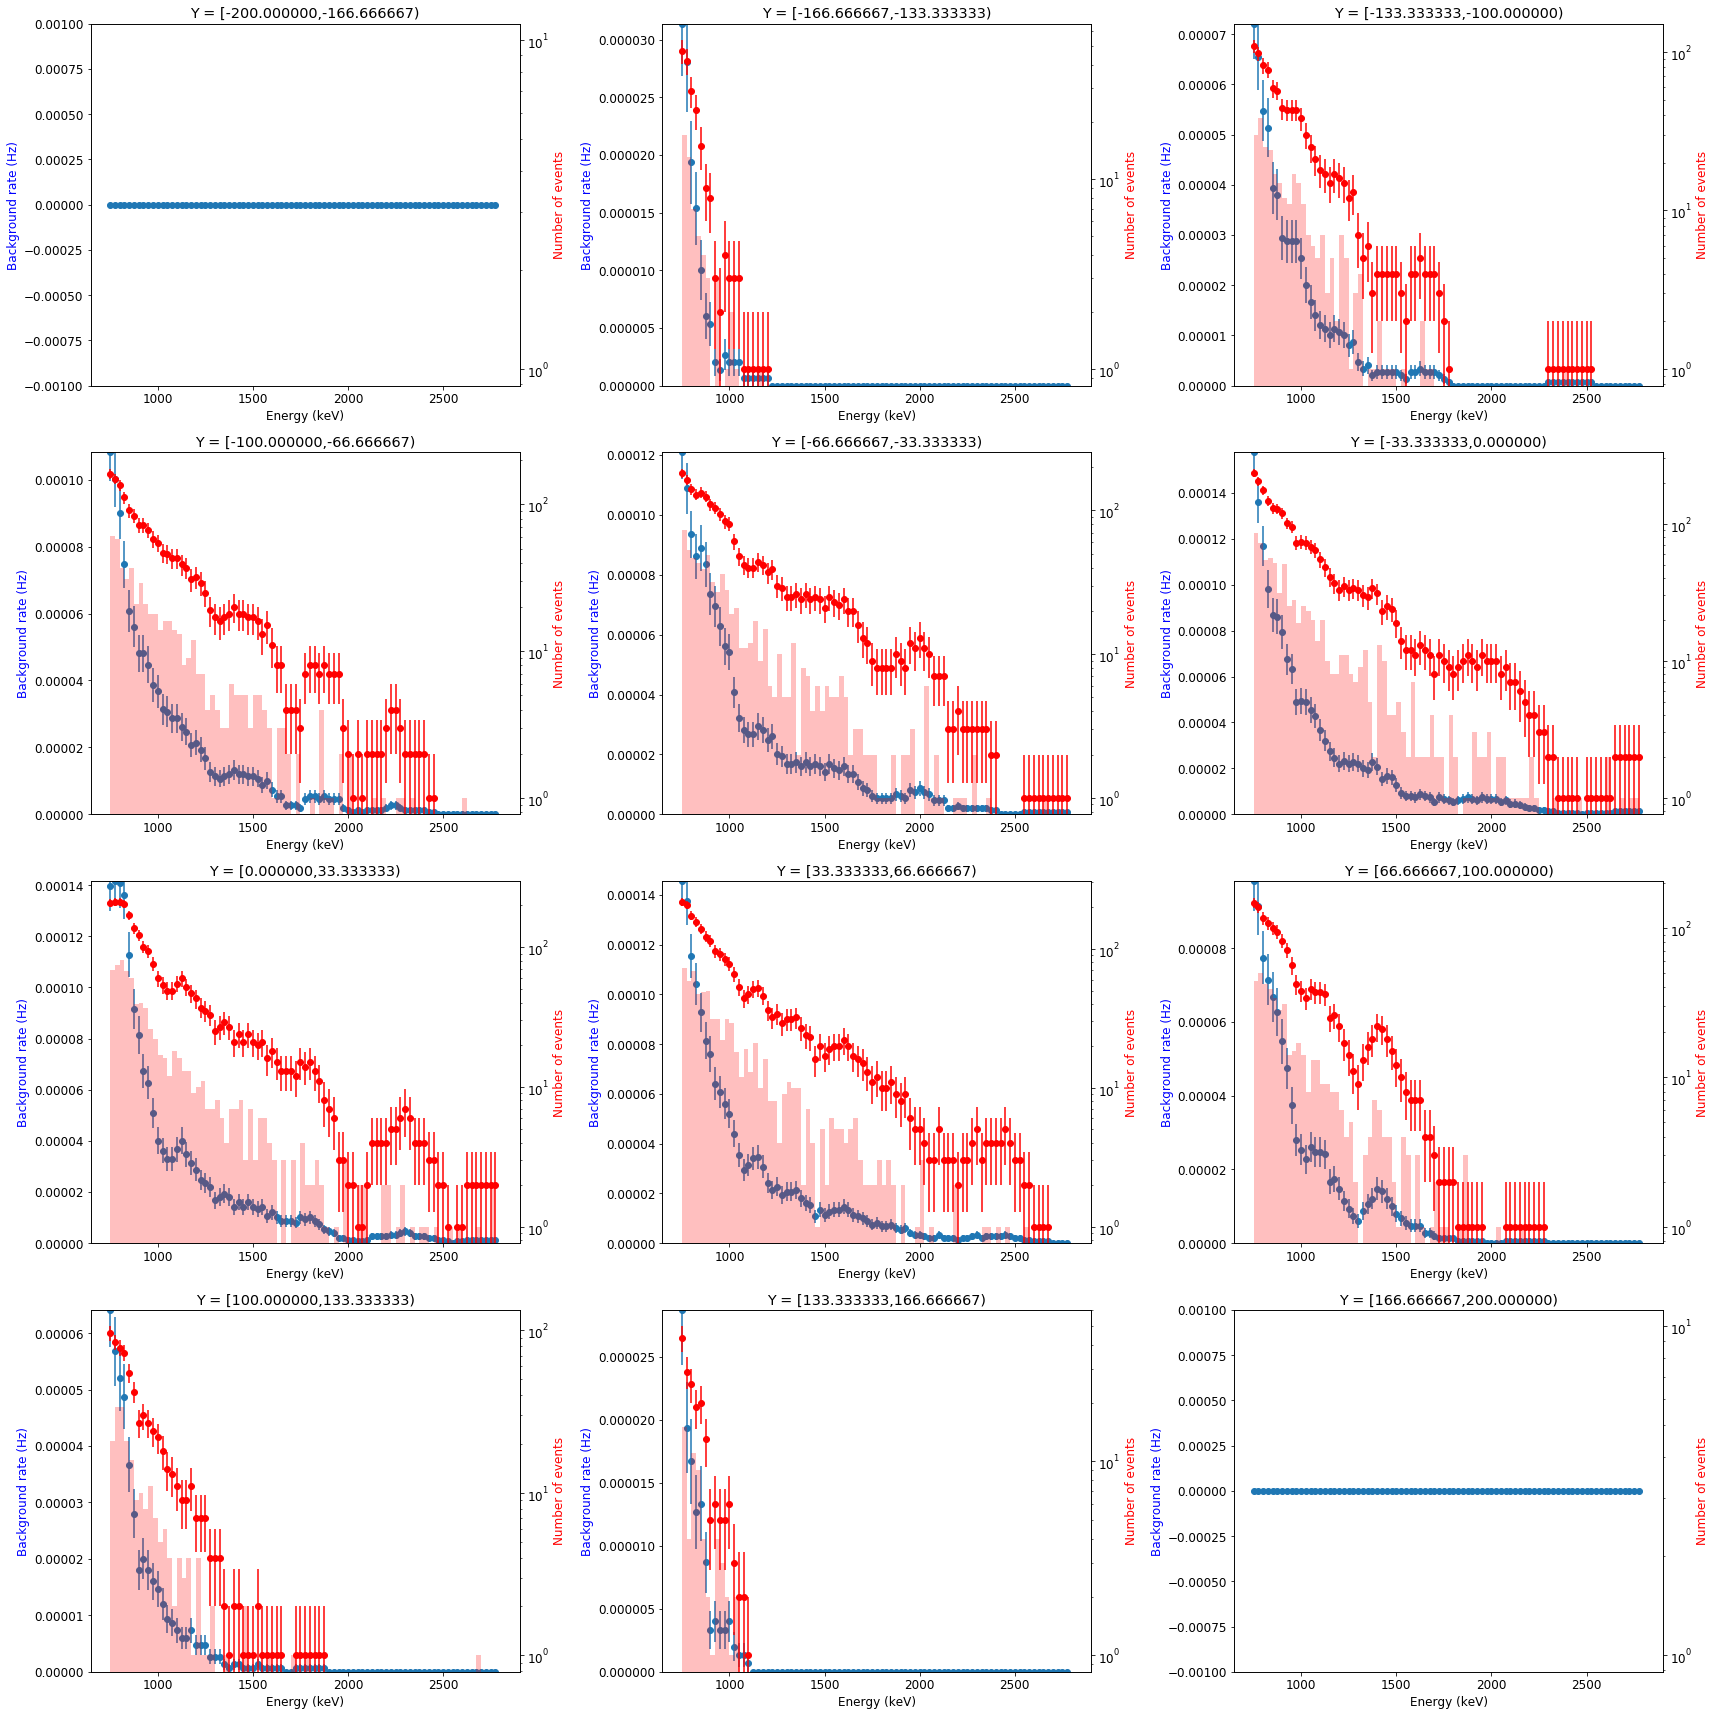

In [47]:
var_min = -200
var_max = 200
step = (var_max - var_min)/12
yrange = np.arange(var_min, var_max, step)

tot_rate_y = []

n_row = 3
nrows = len(yrange)//n_row

if len(trange)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, y in enumerate(yrange):
    title = "Y = [{0:2f},{1:2f})".format(y, y+step)
    sel = coref.in_range(sum_kdst.Y, y, y+step)
    sel = sel & (coref.in_range(sum_kdst.Z, 490, 575))
    tot_rate_y.append(plot_bg(sum_kdst[sel], 3., 4., 750, 2800, 25, sum_runTime, title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

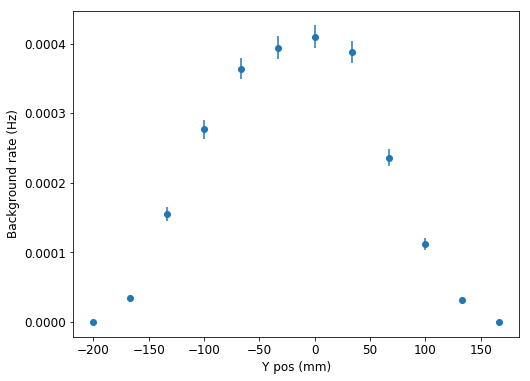

In [48]:
rate = list([x[0] for x in tot_rate_y])
rate_err = list([x[1] for x in tot_rate_y])
plt.errorbar(yrange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Y pos (mm)")
plt.ylabel("Background rate (Hz)")

#### Time dependance (old run)

Bg rate for 07-16 21:46:45 --- 07-17 00:19:59 = 0.010441448679252495 +- 0.00043506036163552065
Bg rate for 07-17 00:19:59 --- 07-17 02:53:13 = 0.010477703709388789 +- 0.0004358150202454268
Bg rate for 07-17 02:53:13 --- 07-17 05:26:27 = 0.009680093046390335 +- 0.0004188985946019667
Bg rate for 07-17 05:26:27 --- 07-17 07:59:42 = 0.00926316019982296 +- 0.00040977808152821866
Bg rate for 07-17 07:59:42 --- 07-17 10:32:56 = 0.009154395109414081 +- 0.0004073652357352946
Bg rate for 07-17 10:32:56 --- 07-17 13:06:10 = 0.009625710501185894 +- 0.0004177202558553573


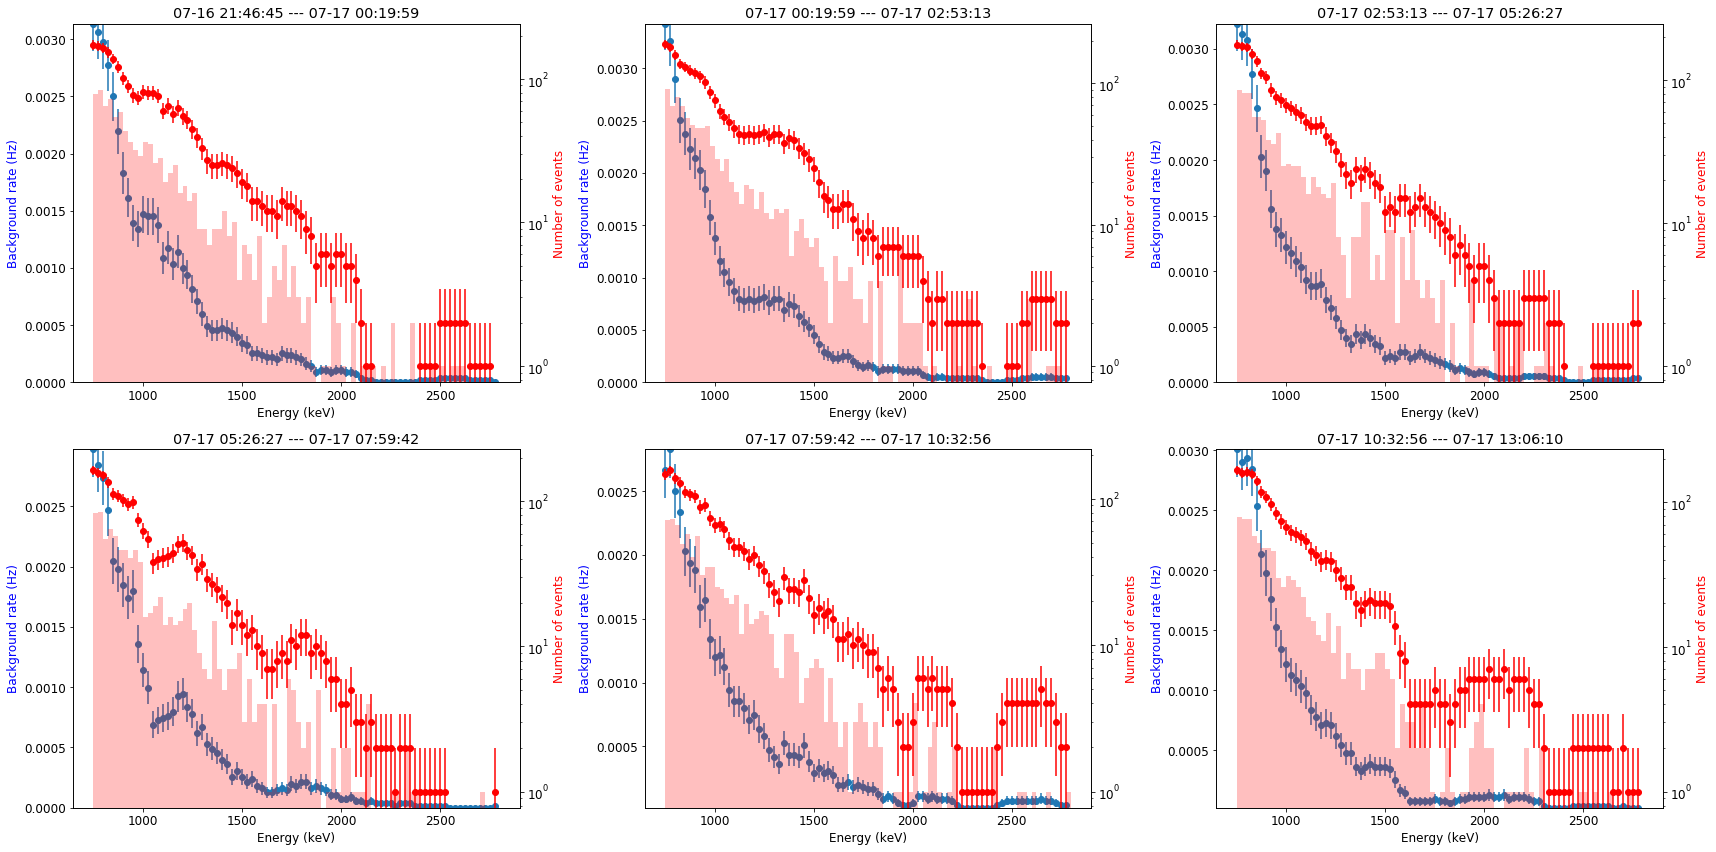

In [49]:
runNo = 4495

var_min = corr_kdst[runNo].time.min()
var_max = corr_kdst[runNo].time.max()
step = (var_max - var_min)/6
trange = np.arange(var_min, var_max, step)

tot_rate_z = []

n_row = 3
nrows = len(trange)//n_row

if len(trange)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, t in enumerate(trange):
    title = datetime.datetime.fromtimestamp(int(t)).strftime('%m-%d %H:%M:%S') + " --- " + datetime.datetime.fromtimestamp(int(t+step)).strftime('%m-%d %H:%M:%S') 
    sel = coref.in_range(corr_kdst[runNo].Z, 490, 575) 
    sel = sel & (coref.in_range(corr_kdst[runNo].time, t, t+step))
    tot_rate_z.append(plot_bg(corr_kdst[runNo][sel], 3., 4., 750, 2800, 25, runTime[runNo], title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

Radon disappearance lifetime: 215519.17922120224 s


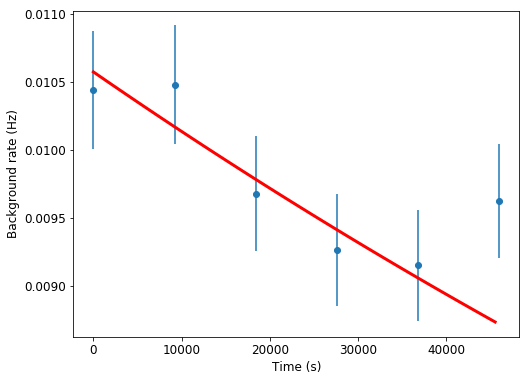

In [52]:
rate = list([x[0] for x in tot_rate_z])
rate_err = list([x[1] for x in tot_rate_z])
plt.errorbar(trange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Time (s)")
plt.ylabel("Background rate (Hz)")

trange = np.array(trange)
trange = trange - trange[0]

seed = (rate[0], trange[-1]/np.log(rate[0]/rate[-1]), rate[-1])
bound = ([0., trange[-1]/np.log(rate[0]/rate[-1])*0.01, 0.], [1., trange[-1]/np.log(rate[0]/rate[-1])*100., 1.])
f    = fitf.fit(c_expo, trange, np.array(rate), seed, fit_range=[trange[0],trange[-1]], sigma=np.array(rate_err), bounds=bound)

times = np.arange(trange[0], trange[-1], (trange[-1]-trange[0])/100)
plt.plot(times, f.fn(times), fitOpt, lw=3)

print("Radon disappearance lifetime: {} s".format(f.values[1]))


## No-cathode selection

Bg rate for R4495, castle opened, 4 days without cold getter = 0.2058016785686694 +- 0.0019314950244055606
Bg rate for R4575, castle opened, 20 days without cold getter = 0.21209131243803475 +- 0.0016459495412364008
Bg rate for Run 4576-4588, castle closed = 0.009824715728518271 +- 8.098882601484602e-05


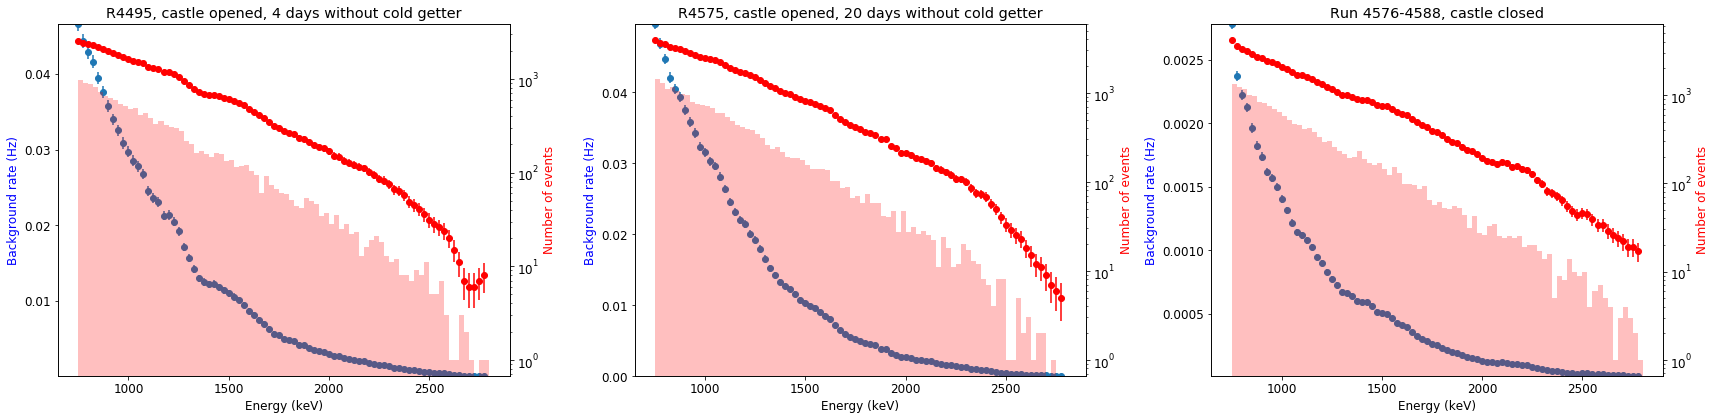

In [53]:
fig, ax = plt.subplots(1,3, figsize=(24,6))

title = "R4495, castle opened, 4 days without cold getter"
runNo = 4495
sel = coref.in_range(corr_kdst[runNo].Z, 0., 490.) 
plot_bg(corr_kdst[runNo][sel], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[0])

title = "R4575, castle opened, 20 days without cold getter"
runNo = 4575
sel = coref.in_range(corr_kdst[runNo].Z, 0., 490.) 
plot_bg(corr_kdst[runNo][sel], 3., 4., 750, 2800, 25, runTime[runNo], title, ax[1])

title = "Run 4576-4588, castle closed"
sel = coref.in_range(sum_kdst.Z, 0., 490.) 
rate = plot_bg(sum_kdst[sel], 3., 4., 750, 2800, 25, sum_runTime, title, ax[2])

fig.tight_layout()

#### Time dependance

Bg rate for 08-03 18:53:28 --- 08-06 00:34:19 = 0.01096504346214598 +- 0.00023820171230799485
Bg rate for 08-06 00:38:37 --- 08-07 08:13:54 = 0.010622856879289487 +- 0.0003056383617562478
Bg rate for 08-07 21:07:52 --- 08-11 10:57:20 = 0.00902356869402743 +- 0.00017089601826480113
Bg rate for 08-11 10:59:58 --- 08-15 10:35:06 = 0.009694637122614626 +- 0.00016784891442989152
Bg rate for 08-15 11:14:59 --- 08-18 19:17:05 = 0.009960927723046771 +- 0.00018593401203270747
Bg rate for 08-18 19:22:40 --- 08-21 16:44:05 = 0.00959207507964061 +- 0.00019600168753636617


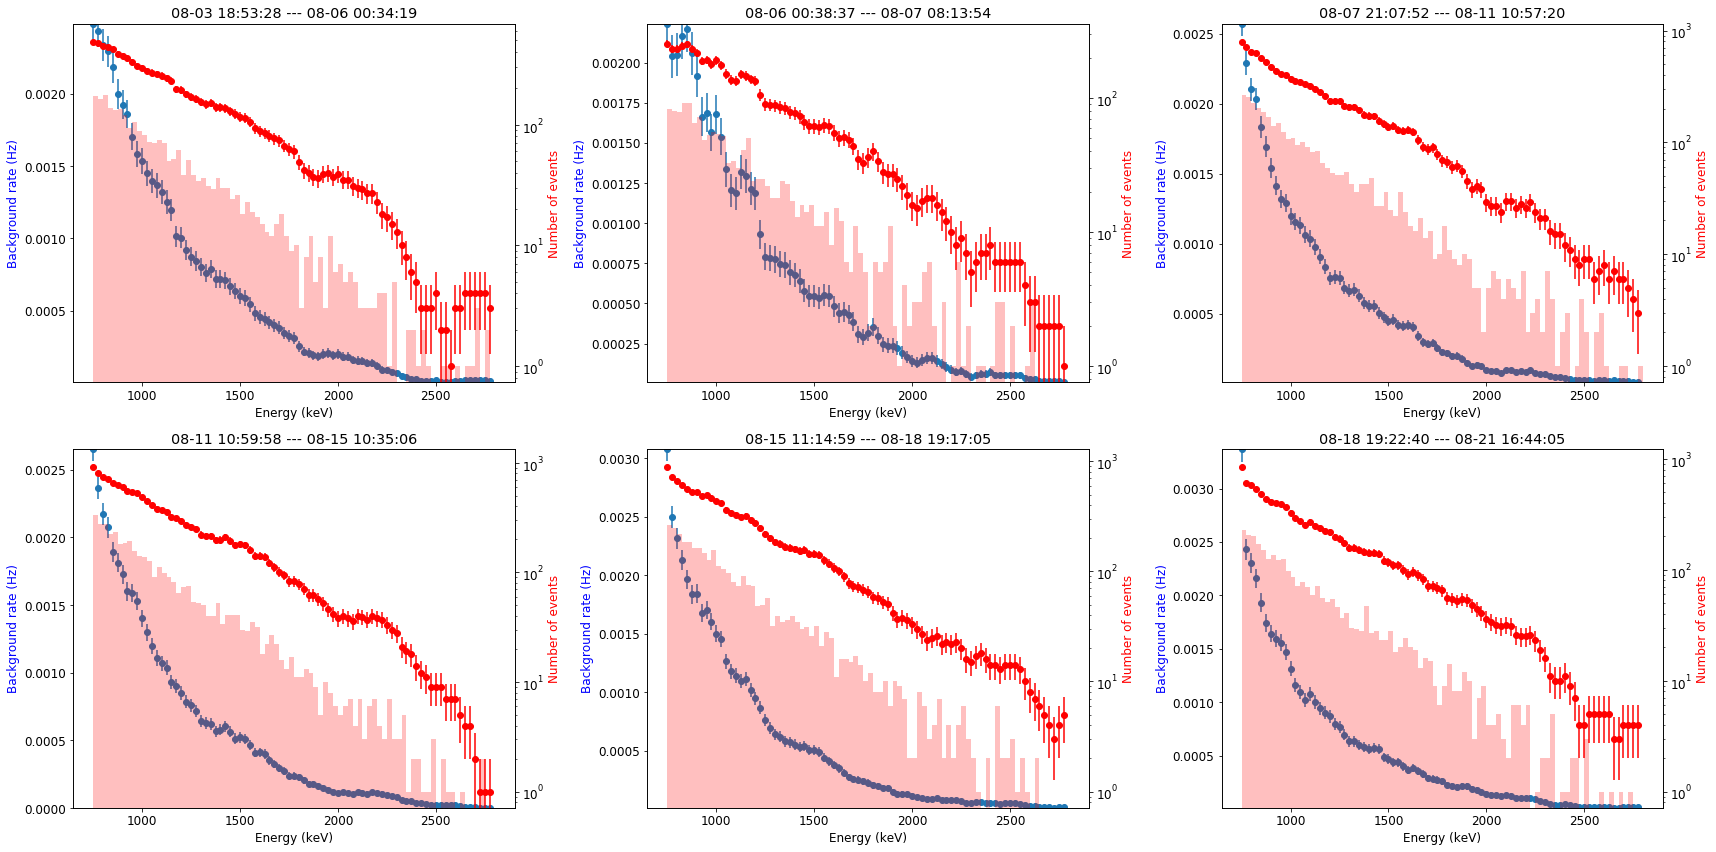

In [54]:
runs = [4576, 4577, 4583, 4584, 4587, 4588]
tot_rate = []
trange = []
n_row = 3
nrows = len(runs)//n_row

if len(runs)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, run in enumerate(runs):
    title = datetime.datetime.fromtimestamp(int(corr_kdst[run].time.min())).strftime('%m-%d %H:%M:%S') + " --- " + datetime.datetime.fromtimestamp(int(corr_kdst[run].time.max())).strftime('%m-%d %H:%M:%S') 
    trange.append(corr_kdst[run].time.mean())
    sel = coref.in_range(corr_kdst[run].Z, 0., 490.) 
    tot_rate.append(plot_bg(corr_kdst[run][sel], 3., 4., 750, 2800, 25, runTime[run], title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

Radon disappearance lifetime: 125729.67113889857 s


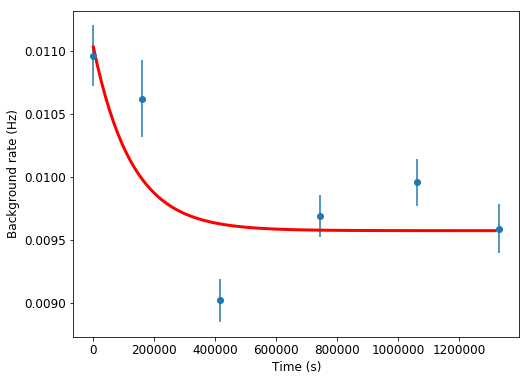

In [56]:
rate = list([x[0] for x in tot_rate])
rate_err = list([x[1] for x in tot_rate])
plt.errorbar(trange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Time (s)")
plt.ylabel("Background rate (Hz)")

trange = np.array(trange)
trange = trange - trange[0]

seed = (rate[0], trange[-1]/np.log(rate[0]/rate[-1]), rate[-1])
bound = ([0., trange[-1]/np.log(rate[0]/rate[-1])*0.01, 0.], [1., trange[-1]/np.log(rate[0]/rate[-1])*100., 1.])
f    = fitf.fit(c_expo, trange, np.array(rate), seed, fit_range=[trange[0],trange[-1]], sigma=np.array(rate_err), bounds=bound)

times = np.arange(trange[0], trange[-1], (trange[-1]-trange[0])/100)
plt.plot(times, f.fn(times), fitOpt, lw=3)

print("Radon disappearance lifetime: {} s".format(f.values[1]))


#### Y dependance

Bg rate for Y = [-200.000000,-166.666667) = 1.7358154997382105e-05 +- 3.404214271216133e-06
Bg rate for Y = [-166.666667,-133.333333) = 0.00012284232767378105 +- 9.056056545421566e-06
Bg rate for Y = [-133.333333,-100.000000) = 0.0009052945452480821 +- 2.45844252093293e-05
Bg rate for Y = [-100.000000,-66.666667) = 0.0013866495357524088 +- 3.042625230886988e-05
Bg rate for Y = [-66.666667,-33.333333) = 0.0015321909891919973 +- 3.1983173867127085e-05
Bg rate for Y = [-33.333333,0.000000) = 0.0015869359395683563 +- 3.2549536219042485e-05
Bg rate for Y = [0.000000,33.333333) = 0.001564904435148602 +- 3.232280318039366e-05
Bg rate for Y = [33.333333,66.666667) = 0.001383311429022143 +- 3.038960740540227e-05
Bg rate for Y = [66.666667,100.000000) = 0.0009039593025559757 +- 2.4566288412165445e-05
Bg rate for Y = [100.000000,133.333333) = 0.0003491659639858016 +- 1.526796158208912e-05
Bg rate for Y = [133.333333,166.666667) = 5.54125717224121e-05 +- 6.082319929236205e-06
Bg rate for Y = [166.

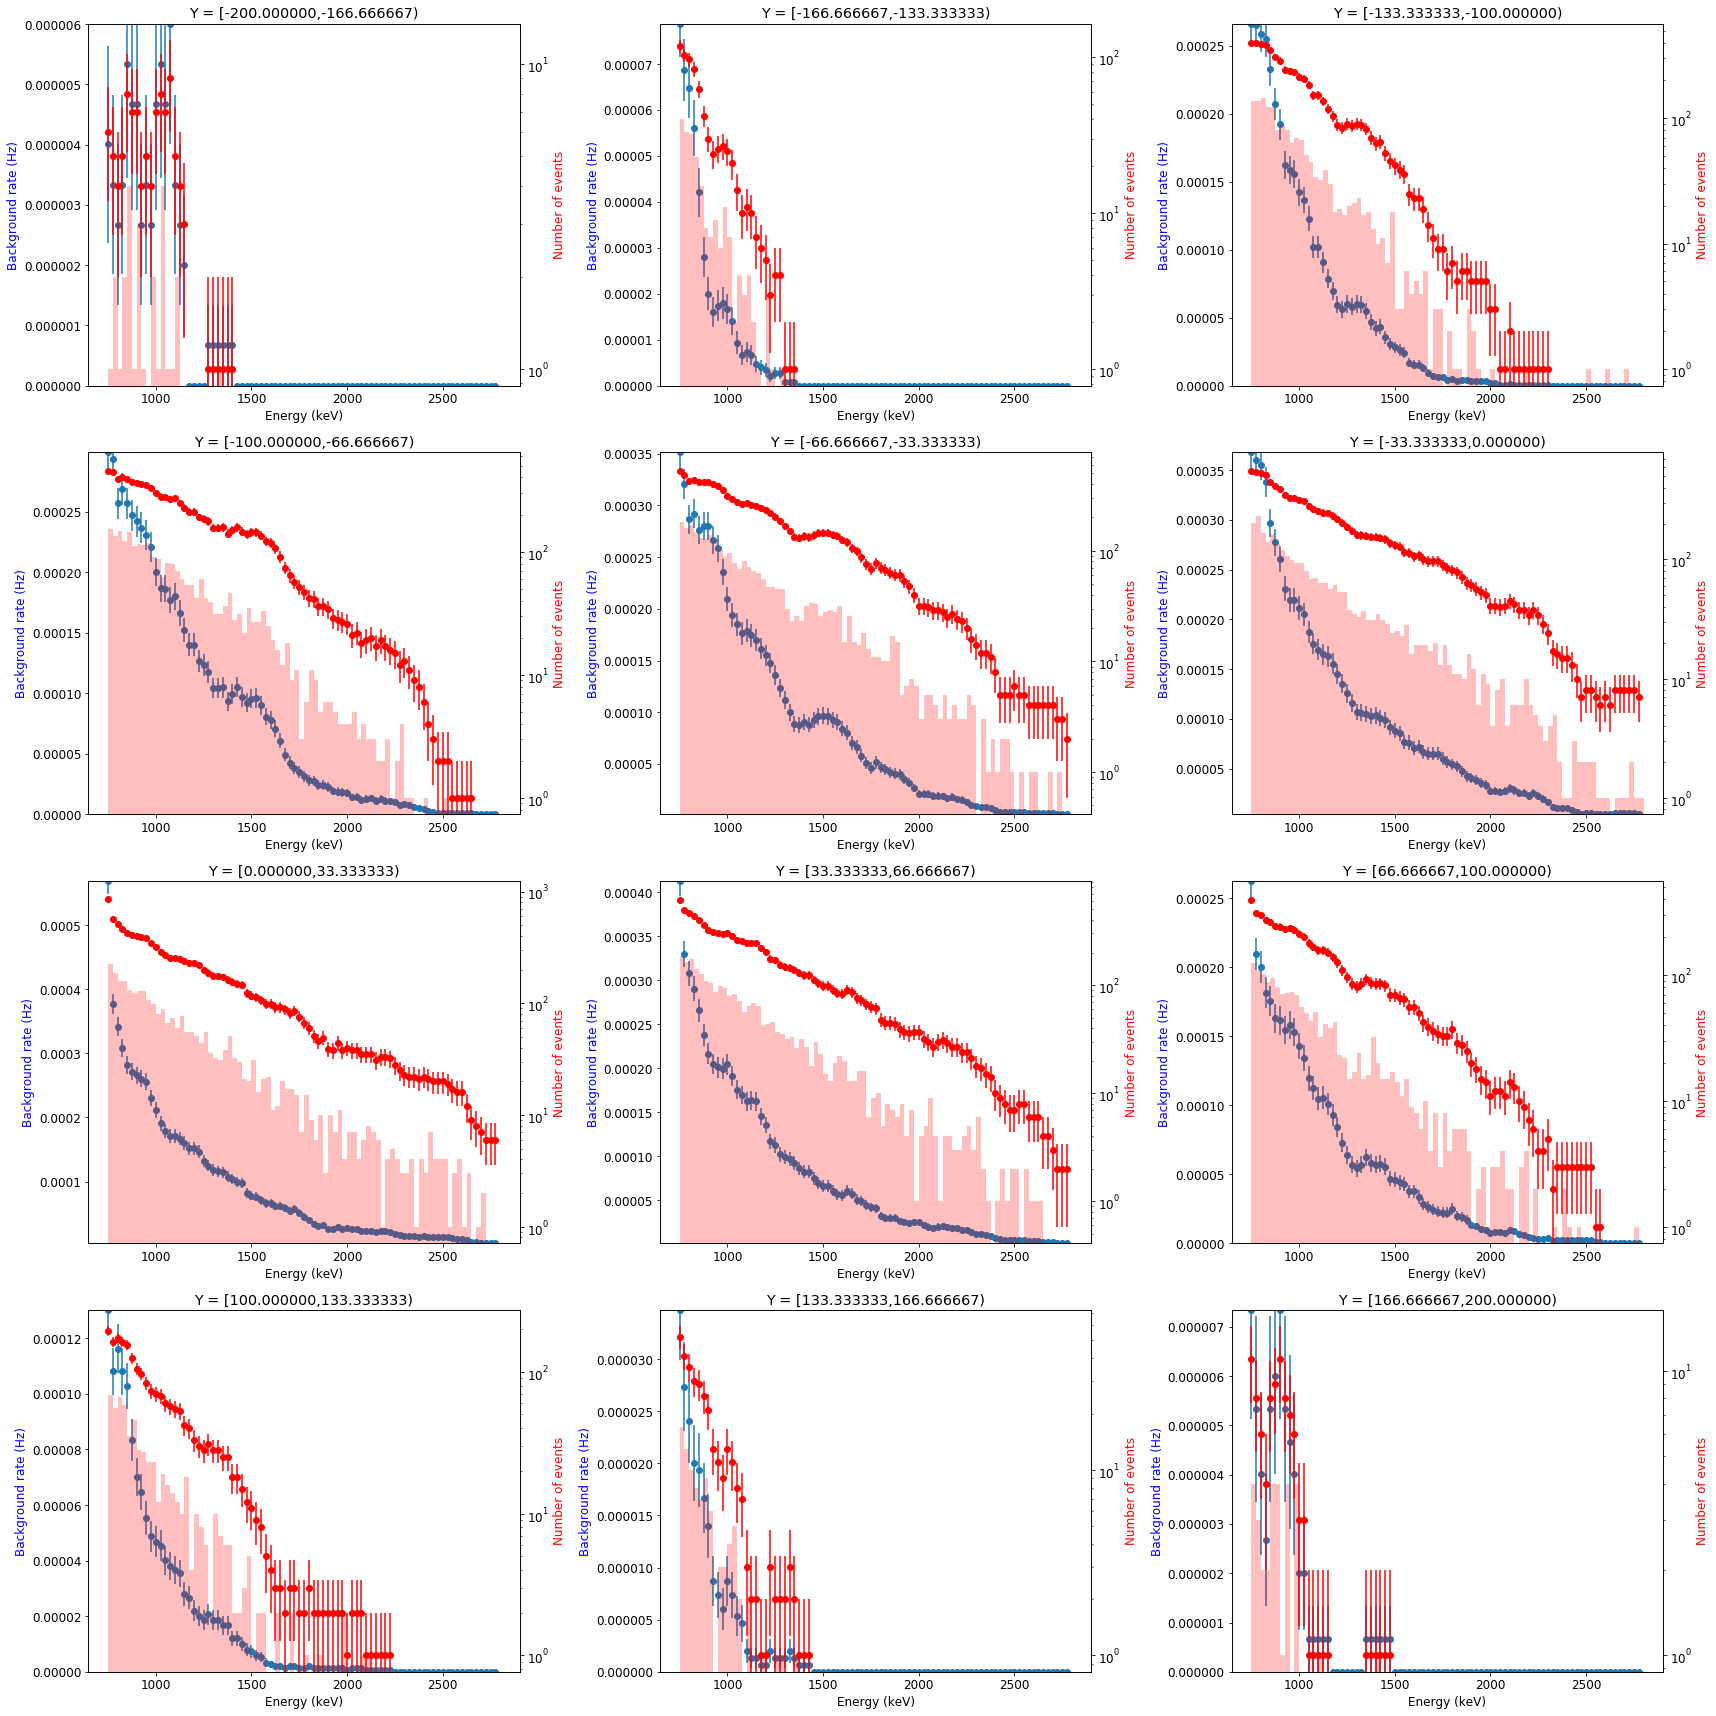

In [57]:
var_min = -200
var_max = 200
step = (var_max - var_min)/12
yrange = np.arange(var_min, var_max, step)

tot_rate_y = []

n_row = 3
nrows = len(yrange)//n_row

if len(trange)%n_row>0:
    nrows +=1
        
fig, axes = plt.subplots(nrows, n_row, figsize=(8*n_row,6*nrows))

for i, y in enumerate(yrange):
    title = "Y = [{0:2f},{1:2f})".format(y, y+step)
    sel = coref.in_range(sum_kdst.Y, y, y+step)
    sel = sel & (coref.in_range(sum_kdst.Z, 0., 490.) )
    tot_rate_y.append(plot_bg(sum_kdst[sel], 3., 4., 750, 2800, 25, sum_runTime, title, axes[i//n_row][i%n_row]))
    
fig.tight_layout()

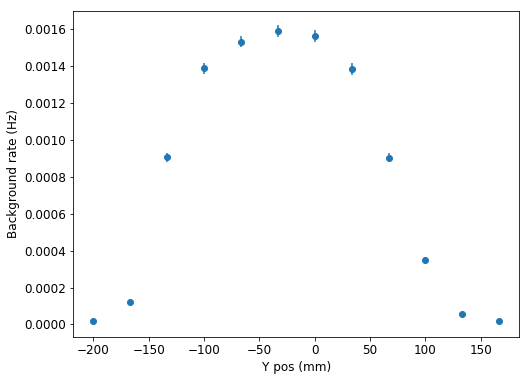

In [58]:
rate = list([x[0] for x in tot_rate_y])
rate_err = list([x[1] for x in tot_rate_y])
plt.errorbar(yrange, rate, yerr=rate_err, fmt='o')
plt.xlabel("Y pos (mm)")
plt.ylabel("Background rate (Hz)")